# Retrieve data

In [9]:
try:
    from google.colab import drive
    is_running_on_colab = True
except ImportError:
    is_running_on_colab = False

if is_running_on_colab:
    # Mount Google Drive
    drive.mount('/content/drive')


# Data Preparation

In [10]:

import time
start_notebook = time.time()
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [11]:
# %cd ..
# %pwd

In [12]:
# Option to generate mock data
generate_mock_data = False # Set to True to generate mock data
max_mock_depth_ft = 2000 # Define maximum depth for mock data
well_name = "LLB-10"
if not generate_mock_data:
  if is_running_on_colab:
    # Load data from Google Drive, if running on Google Colab
    colab_repo_dir = "/content/drive/MyDrive/riset-fttm-gdrive/cuml-tf-model-hydrocarbon-prediction"
    data = pd.read_csv(f"{colab_repo_dir}/data/interpreted/interpreted_{well_name}.csv", sep=',')
  else:
    # Load data from local directory
    data = pd.read_csv(f"./data/interpreted/interpreted_{well_name}.csv", sep=',')
if generate_mock_data:
    print(f"Generating mock data up to {max_mock_depth_ft} ft for well {well_name}...")
    mock_depth_step = 0.5
    mock_dept_values = np.arange(0, max_mock_depth_ft, mock_depth_step)
    num_mock_rows = len(mock_dept_values)

    mock_data_dict = {'DEPT': mock_dept_values}

    feature_cols_for_mock = ['CALI','DRHO','GR','SR','DR','NPHI_corr','PEF','RHOB_CORR','ROP'] #complete with all necessary features available in LLB-10

    for col in feature_cols_for_mock:
        mock_data_dict[col] = np.random.rand(num_mock_rows) * 100

    mock_data_dict['hydrocarbon_formation_class'] = np.random.randint(0, 2, num_mock_rows)

    data = pd.DataFrame(mock_data_dict)

    print(f"Mock data generated for well {well_name} with {num_mock_rows} rows and columns: {list(data.columns)}.")
    print("Mock data head:")
    print(data.head())

In [13]:
feature_cols = ['DRHO','GR','SR','DR','NPHI_corr','RHOB_CORR']

In [14]:
df=data[feature_cols]

In [15]:
df

,DRHO,GR,SR,DR,NPHI_corr,RHOB_CORR
0,0.051,88.200,0.737,0.741,0.4841,2.103
1,0.050,85.650,0.741,0.742,0.4744,2.130
2,0.064,79.358,0.779,0.743,0.4845,2.177
3,0.077,74.004,0.802,0.744,0.5475,2.184
4,0.081,78.938,0.840,0.744,0.6065,2.142
...,...,...,...,...,...,...
7103,0.206,48.022,1.897,2.186,0.3222,2.595
7104,0.158,51.742,1.858,2.194,0.3199,2.555
7105,0.089,54.041,1.919,2.245,0.3278,2.477
7106,0.052,52.710,1.883,2.291,0.3315,2.432


## Train/Test Splitting

In [16]:
# Misalkan 'data' adalah DataFrame Anda dan 'df' adalah fitur yang telah Anda ekstrak
X = df  # Fitur
y = data['hydrocarbon_formation_class']  # Label

# Split data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [17]:
X_train.describe()

,DRHO,GR,SR,DR,NPHI_corr,RHOB_CORR
count,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000,5686.000000
mean,0.153765,60.130491,1.237495,1.093119,0.410088,2.346557
std,0.103196,11.080574,0.746987,0.231330,0.052479,0.109542
min,-0.196000,17.780000,0.540000,0.603000,0.136700,1.620400
25%,0.091000,52.844750,1.010000,0.962000,0.382900,2.288000
50%,0.134000,62.143500,1.096000,1.039000,0.408500,2.353000
75%,0.187000,68.129500,1.243000,1.162000,0.442000,2.410000
max,0.930000,90.688000,14.701000,2.929000,0.623900,3.433000


## Data Imbalance Handling

In [18]:
from imblearn.over_sampling import SMOTE

In [19]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
# X_train and y_train are available from CELL INDEX 10
print("Original training data shape:", X_train.shape, y_train.shape)
print("Original training class distribution:\n", y_train.value_counts())

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nShape of training data after SMOTE:", X_train_smote.shape, y_train_smote.shape)
print("Class distribution after SMOTE:\n", y_train_smote.value_counts())

# Update X_train and y_train to be the oversampled versions
X_train = X_train_smote
y_train = y_train_smote

Original training data shape: (5686, 6) (5686,)
Original training class distribution:
 hydrocarbon_formation_class
0    5326
1     360
Name: count, dtype: int64

Shape of training data after SMOTE: (10652, 6) (10652,)
Class distribution after SMOTE:
 hydrocarbon_formation_class
0    5326
1    5326
Name: count, dtype: int64


## Apply Quantile Transformation

In [20]:
from sklearn.preprocessing import QuantileTransformer
def transform_quantile(X_train, X_test, X):
    qt_transformer = QuantileTransformer(output_distribution='normal')
    dfs = [X_train, X_test, X]
    qt_dfs = [None,None,None]
    for i, df in enumerate(dfs):
        if (i == 0): #only perform fit_transform on training data
            qt_dfs[i] = pd.DataFrame(qt_transformer.fit_transform(df))
        else:
            qt_dfs[i] = pd.DataFrame(qt_transformer.transform(df))
        qt_dfs[i].columns = df.columns.values
        qt_dfs[i].index = df.index.values
    return qt_dfs[0], qt_dfs[1], qt_dfs[2] #X_train, X_test, X

In [21]:
X_train, X_test, X = transform_quantile(X_train, X_test, X)

## Feature Scaling

karena menggunakan Quatile transformation dengan output gaussian, masing masing kolom secara otomatis ditransformasi ke distribusi normal baku, atau distribusi normal dengan rataan nol dan standar deviasi 1, oleh karena itu tidak diperlukan tambahan scaling.

In [22]:
X_train.describe()

,DRHO,GR,SR,DR,NPHI_corr,RHOB_CORR
count,10652.000000,10652.000000,10652.000000,10652.000000,10652.000000,10652.000000
mean,0.000256,0.001791,-0.002334,-0.001100,-0.004046,0.002529
std,0.999405,1.001676,1.001749,1.003465,1.002163,0.997735
min,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
25%,-0.678433,-0.673007,-0.673702,-0.678433,-0.677696,-0.669426
50%,0.002509,0.004862,-0.003764,-0.001255,-0.003764,0.003764
75%,0.669489,0.676936,0.670557,0.674116,0.671518,0.673794
max,5.199338,5.199338,5.199338,5.199338,5.199338,5.199338


# Training setup

In [23]:
import time
import numpy as np
from sklearn.model_selection import GridSearchCV


sk_train_accuracy={}
sk_test_accuracy={}

cu_train_accuracy={}
cu_test_accuracy={}

sk_crossValidation_accuracy={}
cu_crossValidation_accuracy={}

sk_models = {} #sklearn models
cu_models = {} #cuml models

sk_times = {}
cu_times = {}

sk_pred = {}
cu_pred = {}

sk_pred_times = {}
cu_pred_times = {}

In [24]:
# test CuML availability & is working
try:
    import cuml
    kmeans = cuml.KMeans(n_clusters=2)
    # Create minimal dummy data
    dummy_data = np.array([[1, 2], [1.5, 1.8], [5, 8], [8, 8]])
    kmeans.fit(dummy_data)
    # Attempt to fit the model
    has_cuml = True
    print("cuML is found and working")
except ImportError:
    has_cuml = False
    print("cuML not found. Please ensure cuML is installed.")
except Exception as e:
    has_cuml = False
    print(f"cuML couldn't be initialized or used. Error: {e}")


cuML not found. Please ensure cuML is installed.


# Models

## SVM

In [25]:
model_name = "SVM"

In [26]:
from sklearn.svm import SVC as SklearnSVC
# Attempt to import cuML's SVC
try:
    from cuml.svm import SVC as cuMLSVC
except ImportError:
    print("cuML SVC not available. Please ensure cuML is installed and compatible with your environment.")

cuML SVC not available. Please ensure cuML is installed and compatible with your environment.


In [27]:
# Parameter grid for both models
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# 1) scikit-learn SVM with GridSearchCV
sk_models[model_name] = GridSearchCV(
    estimator=SklearnSVC(kernel='rbf'),
    param_grid=param_grid,
    cv=5,
    verbose=3,
    n_jobs=-1
)

time_start = time.time()
sk_models[model_name].fit(X_train, y_train)
time_end = time.time()
sk_times[model_name] = time_end - time_start

# 2) cuML SVM with the same GridSearchCV
if has_cuml:
    cu_models[model_name] = GridSearchCV(
        estimator=cuMLSVC(kernel='rbf'),
        param_grid=param_grid,
        cv=5,
        verbose=3,
        # Note: cuML estimator runs on GPU; this grid search runs on CPU orchestrating GPU calls
        n_jobs=1  # avoid multiprocessing issues with GPU
    )

    time_start = time.time()
    cu_models[model_name].fit(X_train, y_train)
    time_end = time.time()
    cu_times[model_name] = time_end - time_start
    print(f"cuml GridSearchCV training time ({model_name}) : {cu_times[model_name]:.2f} seconds")
    print(f"cuml Best parameters ({model_name}): {cu_models[model_name].best_params_}")
else:
    print("cuML is not installed or GPU not available. Please install RAPIDS cuML to run this benchmark.")

print(f"scikit-learn GridSearchCV training time ({model_name}) : {sk_times[model_name]:.2f} seconds")
print(f"scikit-learn Best parameters ({model_name}): {sk_models[model_name].best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
cuML is not installed or GPU not available. Please install RAPIDS cuML to run this benchmark.
scikit-learn GridSearchCV training time (SVM) : 4.38 seconds
scikit-learn Best parameters (SVM): {'C': 10, 'gamma': 'auto'}


## K-Nearest Neighbors

In [28]:
model_name = "KNN"

In [29]:
from sklearn.neighbors import KNeighborsClassifier as SklearnKNeighborsClassifier
# Attempt to import cuML's KNeighborsClassifier
try:
    from cuml.neighbors import KNeighborsClassifier as cuMLKNeighborsClassifier
    # has_cuml is already defined from SVM section, assuming if SVM cuml is available, KNN cuml is too.
except ImportError:
    # If cuML was previously found but KNN specific part is missing, update has_cuml for KNN context if necessary
    # For simplicity, we rely on the initial has_cuml check. If specific components are missing,
    # the cuML KNN block will be skipped or error out, which is acceptable.
    # A more robust check could be:
    # try: from cuml.svm import SVC as cuMLSVC; has_cuml_svm = True except: has_cuml_svm = False
    # try: from cuml.neighbors import KNeighborsClassifier as cuMLKNeighborsClassifier; has_cuml_knn = True except: has_cuml_knn = False
    pass # Rely on global has_cuml

In [30]:
# Parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# 1) scikit-learn KNN with GridSearchCV
sk_models[model_name] = GridSearchCV(
    estimator=SklearnKNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=5,
    verbose=3,
    n_jobs=-1
)

time_start = time.time()
sk_models[model_name].fit(X_train, y_train)
time_end = time.time()
sk_times[model_name] = time_end - time_start

# 2) cuML KNN with the same GridSearchCV (adapted for cuML)
if has_cuml:
    try:
        # Ensure cuMLKNeighborsClassifier was imported
        cuMLKNeighborsClassifier

        cu_models[model_name] = GridSearchCV(
            estimator=cuMLKNeighborsClassifier(), # cuML KNN
            param_grid=param_grid_knn, # Using the same grid, ensure params are compatible
            cv=5,
            verbose=3,
            n_jobs=1 # Potentially can be >1 if managed carefully, but 1 is safer for GPU resources with GridSearchCV
        )

        time_start = time.time()
        # cuML's KNN might prefer numpy arrays or cuDF dataframes
        # X_train and y_train are pandas, which cuml usually handles.
        # If issues arise, convert: X_train_cu = X_train.to_numpy(), y_train_cu = y_train.to_numpy()
        cu_models[model_name].fit(X_train, y_train)
        time_end = time.time()
        cu_times[model_name] = time_end - time_start
        print(f"cuml GridSearchCV training time ({model_name}) : {cu_times[model_name]:.2f} seconds")
        print(f"cuml Best parameters ({model_name}): {cu_models[model_name].best_params_}")
    except NameError: # handles if cuMLKNeighborsClassifier was not imported
        print(f"cuML KNeighborsClassifier not available. Skipping cuML {model_name} training.")
    except Exception as e:
        print(f"An error occurred during cuML {model_name} training: {e}")
        # Optionally, remove the model key if setup failed partway
        if model_name in cu_models: del cu_models[model_name]
        if model_name in cu_times: del cu_times[model_name]

else:
    print(f"cuML is not installed or GPU not available. Skipping cuML {model_name} benchmark.")

print(f"scikit-learn GridSearchCV training time ({model_name}) : {sk_times[model_name]:.2f} seconds")
print(f"scikit-learn Best parameters ({model_name}): {sk_models[model_name].best_params_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
cuML is not installed or GPU not available. Skipping cuML KNN benchmark.
scikit-learn GridSearchCV training time (KNN) : 0.62 seconds
scikit-learn Best parameters (KNN): {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


## Random Forest

In [31]:
model_name = "RF"

In [32]:
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForestClassifier
# Attempt to import cuML's RandomForestClassifier
try:
    from cuml.ensemble import RandomForestClassifier as cuMLRandomForestClassifier
    # has_cuml is already defined, assuming if previous cuML models are available, RF is too.
except ImportError:
    # Pass, relying on global has_cuml. Specific check for cuMLRandomForestClassifier will happen in the training block.
    pass

In [33]:
# Parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200], # Number of trees in the forest
    'max_depth': [None, 10, 20],    # Maximum depth of the tree
    'min_samples_split': [2, 5], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],   # Minimum number of samples required to be at a leaf node
    # 'max_features': ['auto', 'sqrt'] # Number of features to consider when looking for the best split (cuML might have different defaults/options)
    # For cuML compatibility, specific parameters like 'max_features' might need adjustment or careful selection.
    # cuML RandomForestClassifier has slightly different parameter names or accepted values for some arguments.
    # e.g. max_features in cuML can be int, float, or 'auto' (auto is sqrt(n_features)).
}

# 1) scikit-learn RandomForest with GridSearchCV
sk_models[model_name] = GridSearchCV(
    estimator=SklearnRandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5, # Using 3-fold CV for RF due to potentially longer training times
    verbose=3,
    n_jobs=-1
)

time_start = time.time()
sk_models[model_name].fit(X_train, y_train)
time_end = time.time()
sk_times[model_name] = time_end - time_start


# 2) cuML RandomForest with GridSearchCV (adapted for cuML)
if has_cuml:
    try:
        # Ensure cuMLRandomForestClassifier was imported
        cuMLRandomForestClassifier

        # cuML specific parameter adjustments if necessary.
        # For example, cuML's RandomForestClassifier might not support all string options for max_features like sklearn.
        # It typically supports int (number of features) or float (fraction of features). 'auto' is often sqrt(n_features).
        # Let's use a simplified grid or ensure compatibility.
        # The provided param_grid_rf should generally work if 'max_features' is omitted or set to a compatible value.

        cu_models[model_name] = GridSearchCV(
            estimator=cuMLRandomForestClassifier(random_state=42), # cuML RandomForest
            param_grid=param_grid_rf, # Ensure parameters are compatible with cuML RF
            cv=5, # Using 3-fold CV
            verbose=3,
            n_jobs=1 # Safer for GPU resources with GridSearchCV
        )

        time_start = time.time()
        cu_models[model_name].fit(X_train, y_train) # X_train, y_train are pandas, cuML handles this
        time_end = time.time()
        cu_times[model_name] = time_end - time_start
        print(f"cuml GridSearchCV training time ({model_name}) : {cu_times[model_name]:.2f} seconds")
        print(f"cuml Best parameters ({model_name}): {cu_models[model_name].best_params_}")
    except NameError:
        print(f"cuML RandomForestClassifier not available. Skipping cuML {model_name} training.")
    except Exception as e:
        print(f"An error occurred during cuML {model_name} training: {e}")
        if model_name in cu_models: del cu_models[model_name]
        if model_name in cu_times: del cu_times[model_name]
else:
    print(f"cuML is not installed or GPU not available. Skipping cuML {model_name} benchmark.")

print(f"scikit-learn GridSearchCV training time ({model_name}) : {sk_times[model_name]:.2f} seconds")
print(f"scikit-learn Best parameters ({model_name}): {sk_models[model_name].best_params_}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
cuML is not installed or GPU not available. Skipping cuML RF benchmark.
scikit-learn GridSearchCV training time (RF) : 22.02 seconds
scikit-learn Best parameters (RF): {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


# LLB-10 Prediction & Model Evaluation

--- Evaluating: SVM ---

-- scikit-learn --
Prediction Duration: 0.24 seconds
Train Accuracy: 0.9768
Test Accuracy: 0.9473
Best Cross-Validation Score: 0.9711
Training Duration: 4.38 seconds
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1332
           1       0.55      0.86      0.67        90

    accuracy                           0.95      1422
   macro avg       0.77      0.90      0.82      1422
weighted avg       0.96      0.95      0.95      1422

Confusion Matrix (Test Set):


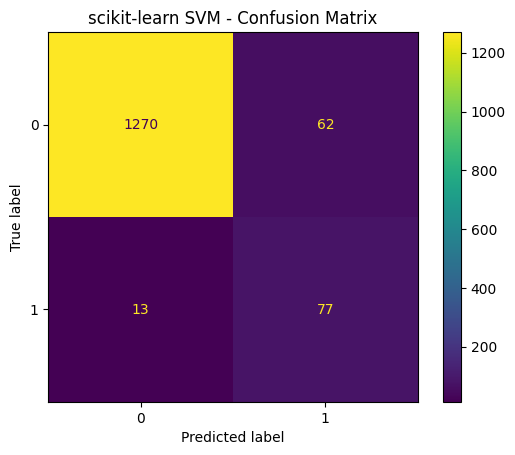


-- cuML --
cuML SVM was not run as cuML model for it is not available.


--- Evaluating: KNN ---

-- scikit-learn --
Prediction Duration: 0.06 seconds
Train Accuracy: 1.0000
Test Accuracy: 0.9437
Best Cross-Validation Score: 0.9693
Training Duration: 0.62 seconds
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1332
           1       0.53      0.96      0.68        90

    accuracy                           0.94      1422
   macro avg       0.76      0.95      0.83      1422
weighted avg       0.97      0.94      0.95      1422

Confusion Matrix (Test Set):


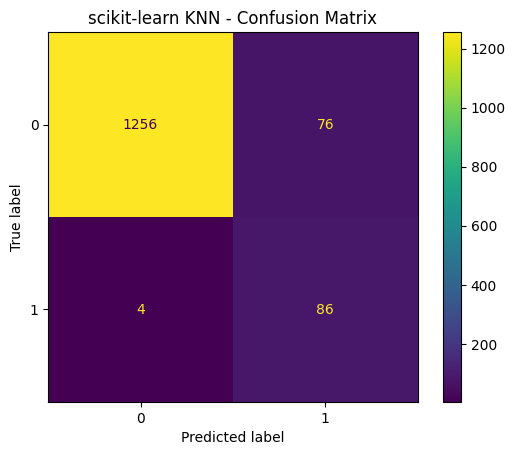


-- cuML --
cuML KNN was not run as cuML model for it is not available.


--- Evaluating: RF ---

-- scikit-learn --
Prediction Duration: 0.04 seconds
Train Accuracy: 0.9995
Test Accuracy: 0.9634
Best Cross-Validation Score: 0.9795
Training Duration: 22.02 seconds
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1332
           1       0.66      0.86      0.75        90

    accuracy                           0.96      1422
   macro avg       0.83      0.91      0.86      1422
weighted avg       0.97      0.96      0.97      1422

Confusion Matrix (Test Set):


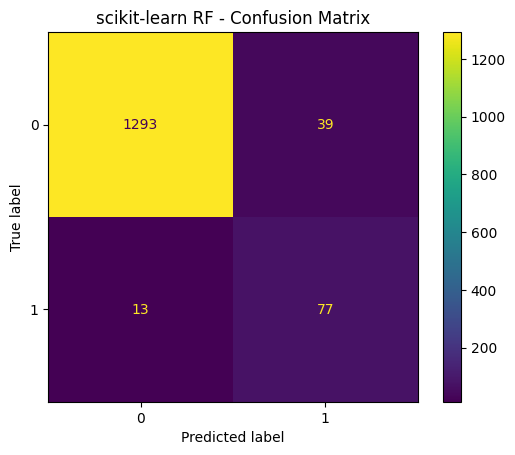


-- cuML --
cuML RF was not run as cuML model for it is not available.



Summary of Accuracies and Times:
scikit-learn Train Accuracies: {'SVM': 0.9768118663161848, 'KNN': 1.0, 'RF': 0.9995306045812993}
CuML Train Accuracies: {}
scikit-learn Test Accuracies: {'SVM': 0.9472573839662447, 'KNN': 0.9437412095639943, 'RF': 0.9634317862165963}
CuML Test Accuracies: {}
scikit-learn Cross-Validation Accuracies: {'SVM': np.float64(0.9710855843649414), 'KNN': np.float64(0.9693018993044771), 'RF': np.float64(0.9795349226596872)}
CuML Cross-Validation Accuracies: {}
scikit-learn Training Times: {'SVM': 4.375248193740845, 'KNN': 0.6217172145843506, 'RF': 22.021402597427368}
cuML Training Times: {}
scikit-learn Prediction Times: {'SVM': 0.23671555519104004, 'KNN': 0.056298255920410156, 'RF': 0.03743147850036621}
cuML Prediction Times: {}


In [56]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# --- Comparison and Evaluation ---
model_names = list(sk_models.keys()) # Assuming cu_models will have the same keys if cuML is available

for model_name in model_names:
    print(f"--- Evaluating: {model_name} ---")

    # --- scikit-learn model ---
    if model_name in sk_models:
        print("\n-- scikit-learn --")
        best_sk_model = sk_models[model_name].best_estimator_

        # Predictions
        y_pred_train_sk = best_sk_model.predict(X_train)
        y_pred_test_sk = best_sk_model.predict(X_test)
        start_time = time.time()
        sk_pred[model_name] = best_sk_model.predict(X)
        end_time = time.time()
        sk_pred_times[model_name] = end_time - start_time
        print(f"Prediction Duration: {sk_pred_times[model_name]:.2f} seconds")

        # Accuracy
        train_accuracy_sk = accuracy_score(y_train, y_pred_train_sk)
        test_accuracy_sk = accuracy_score(y_test, y_pred_test_sk)
        sk_train_accuracy[model_name] = train_accuracy_sk
        sk_test_accuracy[model_name] = test_accuracy_sk
        print(f"Train Accuracy: {train_accuracy_sk:.4f}")
        print(f"Test Accuracy: {test_accuracy_sk:.4f}")

        # Cross-validation score
        cv_score_sk = sk_models[model_name].best_score_
        sk_crossValidation_accuracy[model_name] = cv_score_sk
        print(f"Best Cross-Validation Score: {cv_score_sk:.4f}")

        # Duration
        print(f"Training Duration: {sk_times[model_name]:.2f} seconds")

        print("Classification Report (Test Set):")
        print(classification_report(y_test, y_pred_test_sk))

        # Confusion Matrix
        print("Confusion Matrix (Test Set):")
        cm_sk = confusion_matrix(y_test, y_pred_test_sk)
        disp_sk = ConfusionMatrixDisplay(confusion_matrix=cm_sk, display_labels=best_sk_model.classes_)
        disp_sk.plot()
        plt.title(f"scikit-learn {model_name} - Confusion Matrix")
        plt.show()


    # --- cuML model ---
    print("\n-- cuML --")
    if has_cuml and model_name in cu_models:
        best_cu_model = cu_models[model_name].best_estimator_

        # Predictions

        # Note: cuML predict might require cuDF DataFrame or NumPy array
        # Ensuring X_train and X_test are in a compatible format (e.g., NumPy)
        # If they are pandas DataFrames, cuML usually handles them, but explicit conversion can be safer.
        y_pred_train_cu = best_cu_model.predict(X_train.to_numpy() if hasattr(X_train, 'to_numpy') else X_train)
        y_pred_test_cu = best_cu_model.predict(X_test.to_numpy() if hasattr(X_test, 'to_numpy') else X_test)
        start_time = time.time()
        cu_pred[model_name] = best_cu_model.predict(X.to_numpy() if hasattr(X, 'to_numpy') else X)
        end_time = time.time()
        cu_pred_times[model_name] = end_time - start_time
        print(f"Prediction Duration: {cu_pred_times[model_name]:.2f} seconds")

        # If predictions are cuPy arrays, convert them to NumPy for scikit-learn metrics
        if hasattr(y_pred_train_cu, 'get'): # Check if it's a cuPy array
            y_pred_train_cu = y_pred_train_cu.get()
        if hasattr(y_pred_test_cu, 'get'): # Check if it's a cuPy array
            y_pred_test_cu = y_pred_test_cu.get()


        # Accuracy
        train_accuracy_cu = accuracy_score(y_train, y_pred_train_cu) # y_train is pandas Series, compatible
        test_accuracy_cu = accuracy_score(y_test, y_pred_test_cu)   # y_test is pandas Series, compatible
        cu_train_accuracy[model_name] = train_accuracy_cu
        cu_test_accuracy[model_name] = test_accuracy_cu
        print(f"Train Accuracy: {train_accuracy_cu:.4f}")
        print(f"Test Accuracy: {test_accuracy_cu:.4f}")

        # Cross-validation score
        cv_score_cu = cu_models[model_name].best_score_
        cu_crossValidation_accuracy[f"cu_{model_name}"] = cv_score_cu
        print(f"Best Cross-Validation Score: {cv_score_cu:.4f}")

        # Duration
        # if model_name in cu_times: # Check if cu_times was populated
        print(f"Training Duration: {cu_times[model_name]:.2f} seconds")

        print("Classification Report (Test Set):")
        print(classification_report(y_test, y_pred_test_sk))
        
        # Confusion Matrix
        print("Confusion Matrix (Test Set):")
        cm_cu = confusion_matrix(y_test, y_pred_test_cu)
        # Ensure classes are correctly obtained for cuML model if different from sklearn
        # For SVC, .classes_ should be available after fitting.
        disp_cu = ConfusionMatrixDisplay(confusion_matrix=cm_cu, display_labels=best_cu_model.classes_)
        disp_cu.plot()
        plt.title(f"cuML {model_name} - Confusion Matrix")
        plt.show()
    else:
        print(f"cuML {model_name} was not run as cuML model for it is not available.")

    print("\n" + "="*40 + "\n")

print("\nSummary of Accuracies and Times:")
print("scikit-learn Train Accuracies:", sk_train_accuracy)
print("CuML Train Accuracies:", cu_train_accuracy)
print("scikit-learn Test Accuracies:", sk_test_accuracy)
print("CuML Test Accuracies:", cu_test_accuracy)
print("scikit-learn Cross-Validation Accuracies:", sk_crossValidation_accuracy)
print("CuML Cross-Validation Accuracies:", cu_crossValidation_accuracy)
print("scikit-learn Training Times:", sk_times)
print("cuML Training Times:", cu_times)
print("scikit-learn Prediction Times:", sk_pred_times)
print("cuML Prediction Times:", cu_pred_times)

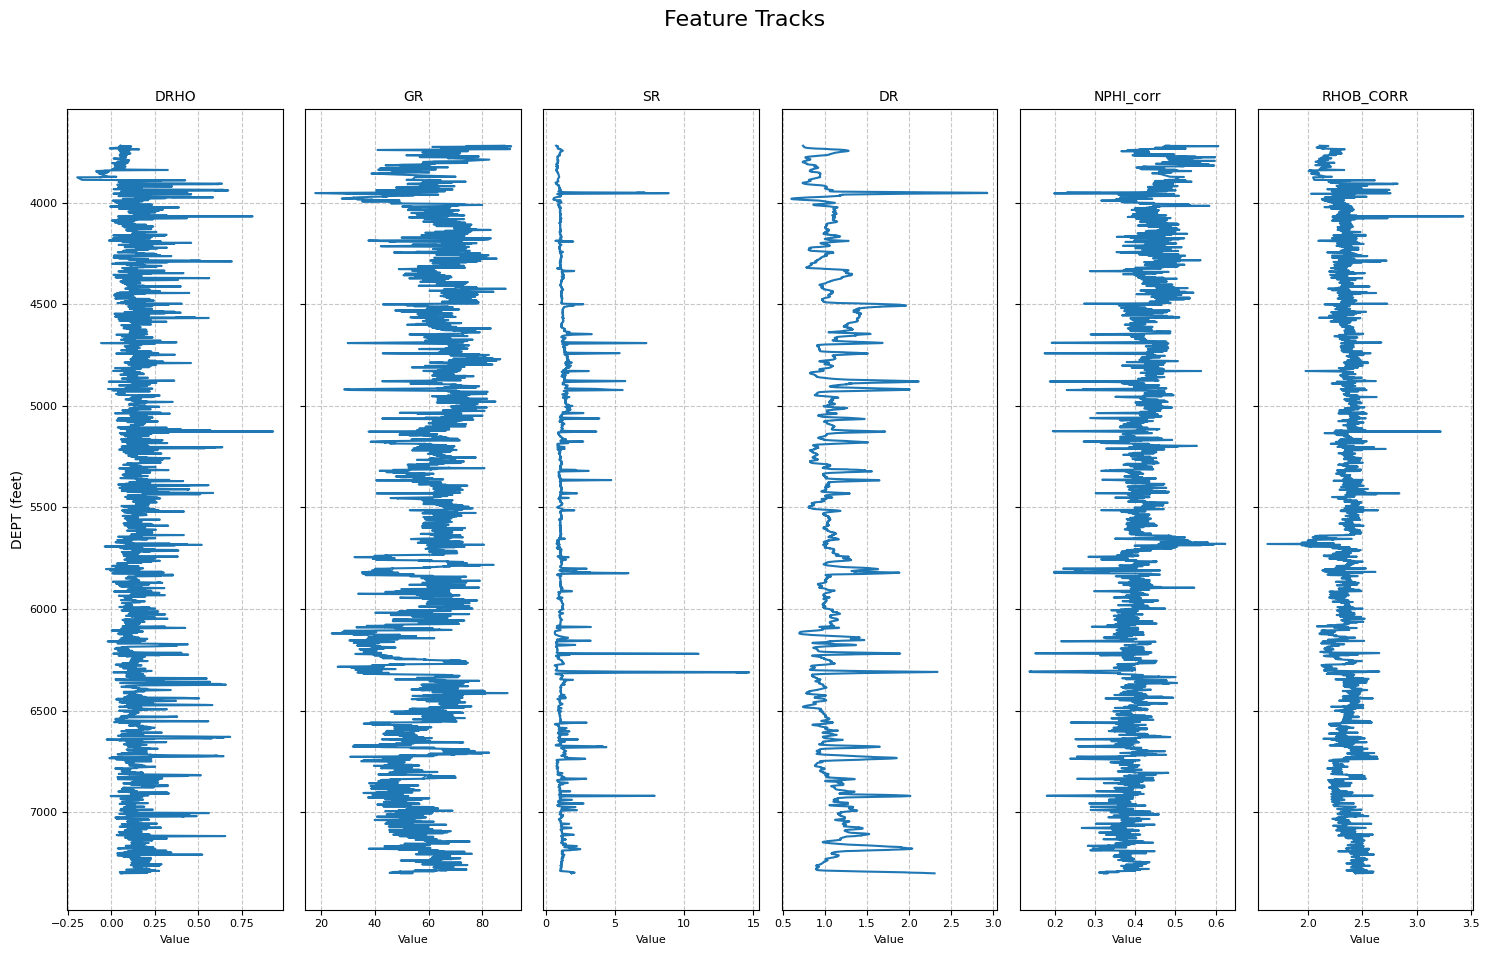

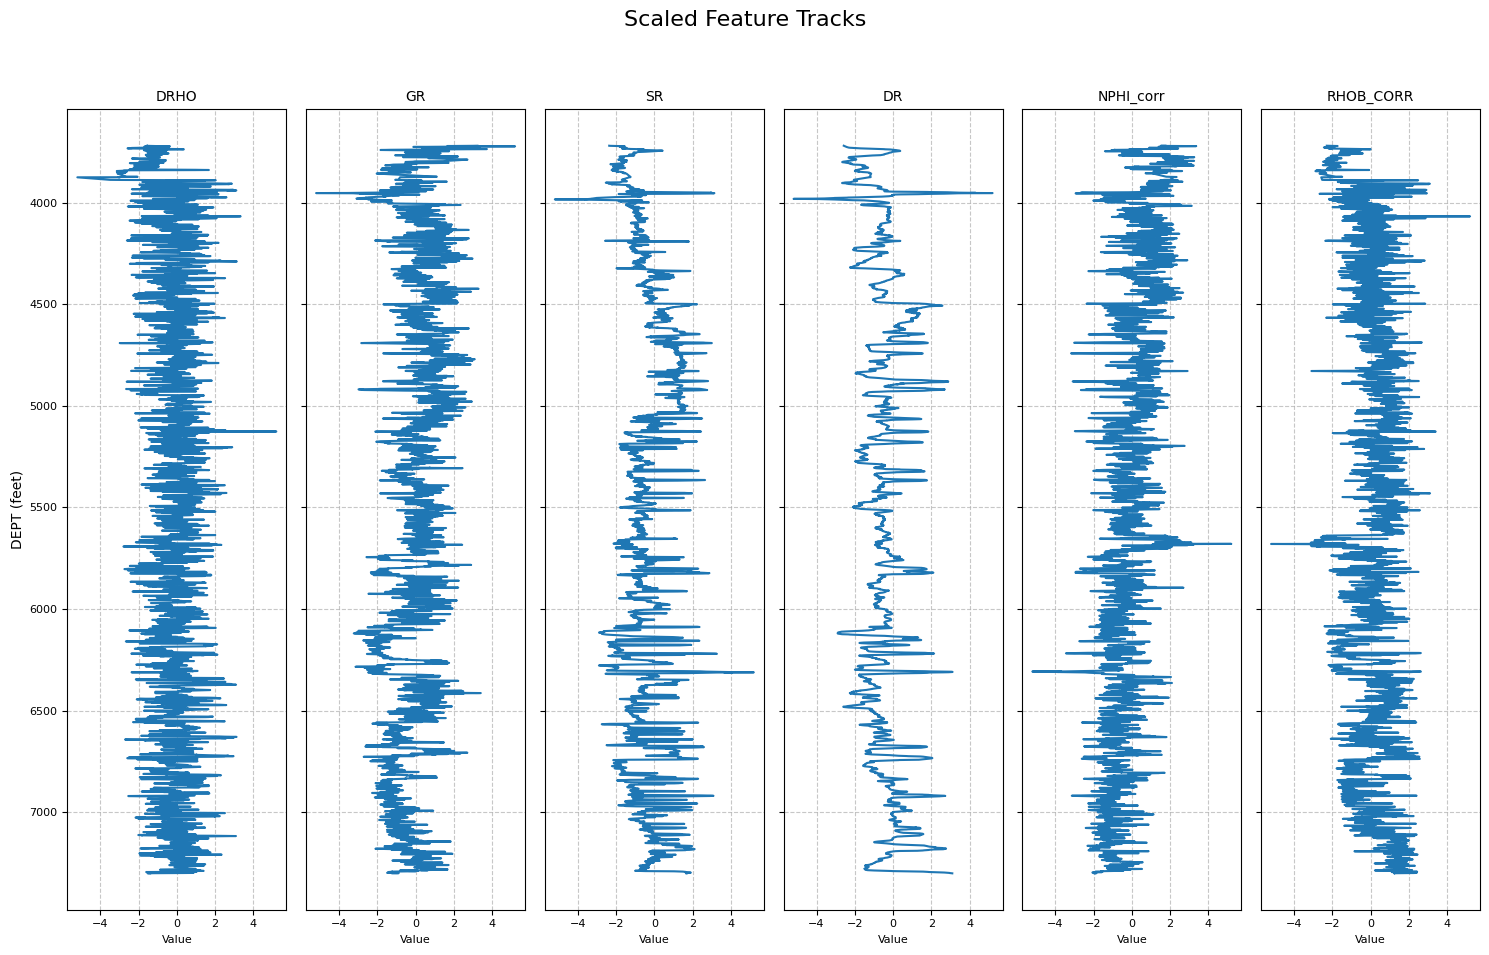

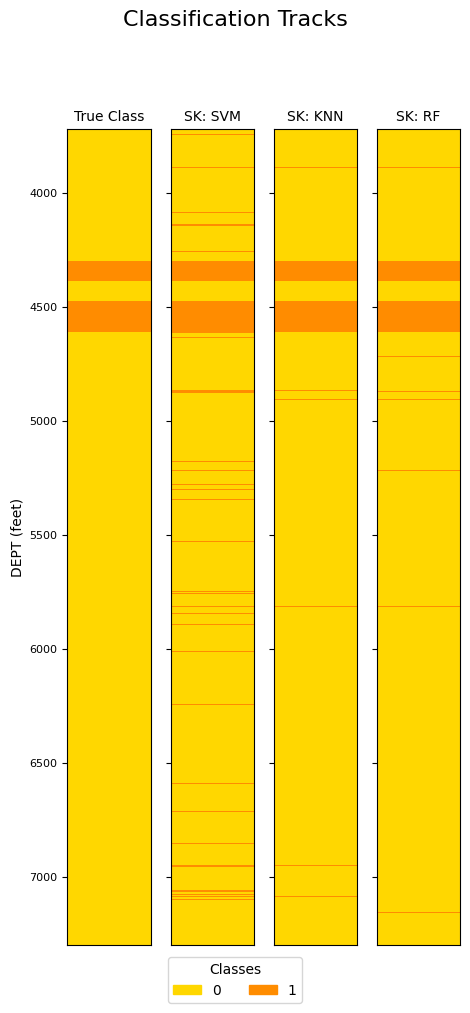

In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

# Ensure all necessary variables are defined from previous cells:
# data, df, y, sk_pred, cu_pred, has_cuml (for cuML models)
# X (to get the index for aligning predictions if they are numpy arrays)

if 'DEPT' not in data.columns:
    print("Error: 'DEPT' column not found in data DataFrame. Cannot generate depth plots.")
else:
    depth_column = data['DEPT']
    feature_names = df.columns.tolist()

    # Prepare labels and predictions (same as before)
    true_labels = y
    all_predictions_to_plot = {}
    all_predictions_to_plot['True Labels'] = true_labels
    for model_name, preds in sk_pred.items():
        all_predictions_to_plot[f'SK: {model_name}'] = preds
    if has_cuml and cu_pred:
        for model_name, preds_cu in cu_pred.items():
            if hasattr(preds_cu, 'get'):
                preds_np = preds_cu.get()
            else:
                preds_np = preds_cu
            all_predictions_to_plot[f'CU: {model_name}'] = preds_np

    # Define colors for classes (same as before)
    if isinstance(true_labels, np.ndarray):
        unique_classes = np.sort(np.unique(true_labels))
    else:
        unique_classes = np.sort(true_labels.unique())

    if len(unique_classes) == 1:
        plot_colors = ['gold']
    elif len(unique_classes) == 2:
        plot_colors = ['gold', 'darkorange']
    else:
        cmap_tab10 = plt.cm.get_cmap('tab10', len(unique_classes))
        plot_colors = [mcolors.to_hex(cmap_tab10(i)) for i in range(len(unique_classes))]

    class_to_int = {cls: i for i, cls in enumerate(unique_classes)}
    cmap_listed = mcolors.ListedColormap(plot_colors[:len(unique_classes)])


    # --- Figure 1: feature Tracks ---
    num_feature_plots = len(feature_names)
    if num_feature_plots > 0:
        fig_features, axes_features = plt.subplots(1, num_feature_plots, figsize=(num_feature_plots * 2.5, 10), sharey=True)
        if num_feature_plots == 1: # Handle single feature case for axes indexing
            axes_features = [axes_features]
        fig_features.suptitle("Feature Tracks", fontsize=16, y=0.98)

        for i, feature_name in enumerate(feature_names):
            ax = axes_features[i]
            ax.plot(data[feature_name].loc[X.index], depth_column.loc[X.index])
            ax.set_title(feature_name, fontsize=10)
            ax.set_xlabel("Value", fontsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        axes_features[0].invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("No features to plot for feature tracks.")

    # --- Figure 2: scaled feature Tracks ---
    num_feature_plots = len(feature_names)
    if num_feature_plots > 0:
        fig_features, axes_features = plt.subplots(1, num_feature_plots, figsize=(num_feature_plots * 2.5, 10), sharey=True)
        if num_feature_plots == 1: # Handle single feature case for axes indexing
            axes_features = [axes_features]
        fig_features.suptitle("Scaled Feature Tracks", fontsize=16, y=0.98)

        for i, feature_name in enumerate(feature_names):
            ax = axes_features[i]
            ax.plot(X[feature_name].loc[X.index], depth_column.loc[X.index])
            ax.set_title(feature_name, fontsize=10)
            ax.set_xlabel("Value", fontsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        axes_features[0].invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("No features to plot for scaled feature tracks.")

    # --- Figure 3: Classification Tracks ---
    num_classification_plots = len(all_predictions_to_plot)
    if num_classification_plots > 0:
        # Adjust figsize: width per plot can be smaller for classification tracks
        fig_class, axes_class = plt.subplots(1, num_classification_plots, figsize=(num_classification_plots * 1.2, 10), sharey=True)
        if num_classification_plots == 1: # Handle single classification plot case
            axes_class = [axes_class]
        fig_class.suptitle("Classification Tracks", fontsize=16, y=0.98)

        plot_order = ['True Labels'] + [k for k in all_predictions_to_plot.keys() if k != 'True Labels']

        for i, title in enumerate(plot_order):
            predictions_data = all_predictions_to_plot[title]
            ax = axes_class[i]

            if isinstance(predictions_data, pd.Series):
                if not predictions_data.index.equals(X.index):
                    # This should ideally not happen with consistent data handling
                    # For safety, one might reindex or ensure alignment upstream
                    print(f"Warning: Index mismatch for {title}. Plotting may be incorrect.")
                mapped_preds = predictions_data.map(class_to_int).fillna(-1)
            elif isinstance(predictions_data, np.ndarray):
                temp_series = pd.Series(predictions_data, index=X.index)
                mapped_preds = temp_series.map(class_to_int).fillna(-1)
            else:
                print(f"Warning: Data for {title} is of unexpected type: {type(predictions_data)}")
                continue

            labels_int = mapped_preds.values.reshape(-1, 1)
            vmin = 0
            vmax = len(plot_colors) - 1

            ax.imshow(labels_int, aspect='auto', cmap=cmap_listed,
                      extent=[0, 1, depth_column.loc[X.index].max(), depth_column.loc[X.index].min()],
                      interpolation='none', vmin=vmin, vmax=vmax)

            if title == 'True Labels':
                ax.set_title("True Class", fontsize=10)
            else:
                ax.set_title(title, fontsize=10)

            ax.set_xticks([])
            ax.set_xlabel("")
            ax.tick_params(axis='y', labelsize=8)
            if i == 0: # Set Y-axis label only for the first plot in this figure
                ax.set_ylabel("DEPT (feet)", fontsize=10)


        if unique_classes is not None and len(unique_classes) > 0:
            patches = [plt.Rectangle((0,0),1,1, color=plot_colors[class_to_int[cls]]) for cls in unique_classes]
            legend_labels = [str(cls) for cls in unique_classes]
            fig_class.legend(patches, legend_labels, loc='lower center', ncol=len(unique_classes), bbox_to_anchor=(0.5, -0.02), title="Classes")

        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
    else:
        print("No classification data to plot.")


# Test Wells

## Configuration

In [37]:
# Configuration for test wells
test_wells = ['LLD-14', 'LLA-2']  # Add more wells here: ["LLD-14", "WELL-X", "WELL-Y"]

# Initialize dictionaries to store results for all test wells
test_wells_data = {}

#! test_feature_cols isnt used in the current 
#! implementation until missing column imputation is
#! implemented. for now, feature_cols are used directly. 
#! Test wells & training well feature columns must be the same
test_feature_cols = {
    'LLD-14': ['DRHO','GR','SR','MR','DR','NPHI_corr','PEF','RHOB_CORR'],
    'LLA-2': ['DRHO','GR','SR','DR','NPHI_corr','RHOB_CORR']
}
test_wells_features = {}
test_wells_features_scaled = {}
test_wells_true_labels = {}
test_wells_sk_pred = {}
test_wells_cu_pred = {}
test_wells_sk_pred_times = {}
test_wells_cu_pred_times = {}
test_wells_sk_accuracy = {}
test_wells_cu_accuracy = {}

print(f"Configured test wells: {test_wells}")

Configured test wells: ['LLD-14', 'LLA-2']


## Load Test Wells Data

In [38]:
# Load data for all test wells
for well_name_test in test_wells:
    print(f"\n--- Loading data for {well_name_test} ---")
    
    if not generate_mock_data:
        if is_running_on_colab:
            # Load data from Google Drive, if running on Google Colab
            colab_repo_dir = "/content/drive/MyDrive/riset-fttm-gdrive/cuml-tf-model-hydrocarbon-prediction"
            test_wells_data[well_name_test] = pd.read_csv(f"{colab_repo_dir}/data/interpreted/interpreted_{well_name_test}.csv", sep=',')
        else:
            # Load data from local directory
            test_wells_data[well_name_test] = pd.read_csv(f"./data/interpreted/interpreted_{well_name_test}.csv", sep=',')
    else:
        # Generate mock data for test well if needed
        print(f"Generating mock data up to {max_mock_depth_ft} ft for well {well_name_test}...")
        mock_depth_step = 0.5
        mock_dept_values = np.arange(0, max_mock_depth_ft, mock_depth_step)
        num_mock_rows = len(mock_dept_values)

        mock_data_dict = {'DEPT': mock_dept_values}

        feature_cols_for_mock = ['CALI','DRHO','GR','MR','NPHI_corr','PEF','RHOB_CORR','ROP']

        for col in feature_cols_for_mock:
            mock_data_dict[col] = np.random.rand(num_mock_rows) * 100

        mock_data_dict['hydrocarbon_formation_class'] = np.random.randint(0, 2, num_mock_rows)

        test_wells_data[well_name_test] = pd.DataFrame(mock_data_dict)

    print(f"{well_name_test} data shape: {test_wells_data[well_name_test].shape}")
    print(f"{well_name_test} data columns: {list(test_wells_data[well_name_test].columns)}")
    print(f"{well_name_test} data head:")
    print(test_wells_data[well_name_test].head())


--- Loading data for LLD-14 ---
LLD-14 data shape: (3501, 36)
LLD-14 data columns: ['WELL', 'DEPT', 'DRHO', 'DT_MAA', 'GR', 'MR', 'SR', 'NPHI', 'PEF', 'RHOB_CORR', 'DR', 'RHOB', 'VSH', 'RW', 'hydrocarbon_formation_class', 'NPHI_corr', 'VCLGR', 'VCLRT', 'VCLND', 'VCL', 'PHID', 'PHIDshc', 'PHI_SIMANDOUX', 'PHIN', 'PHINshc', 'PHIxND', 'PHIE', 'CEC', 'T', 'SWarchie', 'SWsimandoux', 'SWindonesia', 'SWwaxman', 'BVW', 'matrix', 'PERMtimur']
LLD-14 data head:
     WELL    DEPT   DRHO  DT_MAA      GR     MR     SR    NPHI    PEF  \
0  LLD-14  3052.5 -0.055     NaN  38.836  0.594  0.810  0.4513  4.884   
1  LLD-14  3053.0 -0.055     NaN  36.523  0.574  0.805  0.4481  5.164   
2  LLD-14  3053.5 -0.053     NaN  37.434  0.572  0.804  0.4479  5.165   
3  LLD-14  3054.0 -0.047     NaN  39.858  0.581  0.819  0.4464  5.106   
4  LLD-14  3054.5 -0.036     NaN  43.153  0.607  0.828  0.4493  5.057   

   RHOB_CORR  ...      PHIE        CEC          T  SWarchie  SWsimandoux  \
0     1.7606  ...  0.372483 

In [39]:
# Extract features from all test wells data (same features as used for training)
for well_name_test in test_wells:
    print(f"\n--- Extracting features for {well_name_test} ---")
    
    test_wells_features[well_name_test] = test_wells_data[well_name_test][feature_cols]
    # replace above with the line below if you want to use different features for each well, after support for missing column is added (imputation)
    # test_wells_features[well_name_test] = test_wells_data[well_name_test][test_feature_cols[well_name_test]]
    test_wells_true_labels[well_name_test] = test_wells_data[well_name_test]['hydrocarbon_formation_class']

    print(f"{well_name_test} features shape: {test_wells_features[well_name_test].shape}")
    print(f"{well_name_test} class distribution:")
    print(test_wells_true_labels[well_name_test].value_counts())
    print(f"{well_name_test} features head:")
    print(test_wells_features[well_name_test].head())


--- Extracting features for LLD-14 ---
LLD-14 features shape: (3501, 6)
LLD-14 class distribution:
hydrocarbon_formation_class
0    3066
1     435
Name: count, dtype: int64
LLD-14 features head:
    DRHO      GR     SR     DR  NPHI_corr  RHOB_CORR
0 -0.055  38.836  0.810  0.589     0.4513     1.7606
1 -0.055  36.523  0.805  0.562     0.4481     1.7417
2 -0.053  37.434  0.804  0.561     0.4479     1.7385
3 -0.047  39.858  0.819  0.569     0.4464     1.7473
4 -0.036  43.153  0.828  0.593     0.4493     1.7845

--- Extracting features for LLA-2 ---
LLA-2 features shape: (6364, 6)
LLA-2 class distribution:
hydrocarbon_formation_class
0    5951
1     413
Name: count, dtype: int64
LLA-2 features head:
      DRHO    GR      SR      DR  NPHI_corr  RHOB_CORR
0  0.04709  50.6  1.9055  1.4454     0.3114     2.3308
1  0.04108  56.0  1.4723  1.2246     0.3731     2.2186
2  0.01002  61.7  0.8954  0.9818     0.4304     2.1369
3  0.00601  65.6  0.7447  0.8395     0.4164     2.1131
4  0.00802  69.2  0

## Quantile Transformation

In [40]:
# Apply quantile transformation to all test wells data using the same transformer fitted on training data
# We need to use the same transformer that was fitted on the training data (X_train from LLB-10)
# Since we don't have access to the original transformer, we'll refit it on the original LLB-10 training data

# First, get the original training data before SMOTE and scaling
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    df, y, test_size=0.2, stratify=y, random_state=42
)

# Create and fit the quantile transformer on original LLB-10 training data
qt_transformer_for_test_wells = QuantileTransformer(output_distribution='normal')
qt_transformer_for_test_wells.fit(X_train_original)

# Transform all test wells data using the same transformer
for well_name_test in test_wells:
    print(f"\n--- Applying quantile transformation to {well_name_test} ---")
    
    test_wells_features_scaled[well_name_test] = pd.DataFrame(
        qt_transformer_for_test_wells.transform(test_wells_features[well_name_test])
    )
    test_wells_features_scaled[well_name_test].columns = test_wells_features[well_name_test].columns.values
    test_wells_features_scaled[well_name_test].index = test_wells_features[well_name_test].index.values

    print(f"{well_name_test} data after quantile transformation:")
    print(test_wells_features_scaled[well_name_test].describe())
    print(f"{well_name_test} scaled data head:")
    print(test_wells_features_scaled[well_name_test].head())


--- Applying quantile transformation to LLD-14 ---
LLD-14 data after quantile transformation:
              DRHO           GR           SR           DR    NPHI_corr  \
count  3501.000000  3501.000000  3501.000000  3501.000000  3501.000000   
mean     -0.842603     0.578335    -0.529810    -2.067119     0.904272   
std       0.906016     1.119826     0.835897     1.981208     0.671789   
min      -2.915971    -3.260931    -2.216905    -5.199338    -5.199338   
25%      -1.471555    -0.197586    -1.031509    -3.018978     0.702315   
50%      -0.884593     0.708738    -0.785036    -2.023292     1.006211   
75%      -0.328223     1.415629    -0.186756    -1.053106     1.275302   
max       2.028040     5.199338     5.199338     5.199338     2.379951   

         RHOB_CORR  
count  3501.000000  
mean     -1.246897  
std       0.943866  
min      -3.395362  
25%      -1.925859  
50%      -1.258508  
75%      -0.579039  
max       2.618301  
LLD-14 scaled data head:
       DRHO        GR   

## Predict using existing model trained on LLB-10

In [41]:
# Make predictions on all test wells data using LLB-10 trained models
print("Making predictions on all test wells data using LLB-10 trained models...")
print("="*80)

for well_name_test in test_wells:
    print(f"\n--- Predicting for {well_name_test} ---")
    
    # Initialize dictionaries for this well
    test_wells_sk_pred[well_name_test] = {}
    test_wells_cu_pred[well_name_test] = {}
    test_wells_sk_pred_times[well_name_test] = {}
    test_wells_cu_pred_times[well_name_test] = {}
    
    for model_name in sk_models.keys():
        print(f"\n--- Predicting with {model_name} for {well_name_test} ---")
        
        # scikit-learn predictions
        if model_name in sk_models:
            print(f"scikit-learn {model_name} prediction...")
            best_sk_model = sk_models[model_name].best_estimator_
            
            start_time = time.time()
            test_wells_sk_pred[well_name_test][model_name] = best_sk_model.predict(test_wells_features_scaled[well_name_test])
            end_time = time.time()
            test_wells_sk_pred_times[well_name_test][model_name] = end_time - start_time
            
            print(f"scikit-learn {model_name} prediction completed in {test_wells_sk_pred_times[well_name_test][model_name]:.4f} seconds")
            print(f"Prediction shape: {test_wells_sk_pred[well_name_test][model_name].shape}")
            print(f"Predicted class distribution: {np.unique(test_wells_sk_pred[well_name_test][model_name], return_counts=True)}")
        
        # cuML predictions
        if has_cuml and model_name in cu_models:
            print(f"cuML {model_name} prediction...")
            best_cu_model = cu_models[model_name].best_estimator_
            
            start_time = time.time()
            cu_pred_raw = best_cu_model.predict(test_wells_features_scaled[well_name_test].to_numpy() if hasattr(test_wells_features_scaled[well_name_test], 'to_numpy') else test_wells_features_scaled[well_name_test])
            end_time = time.time()
            test_wells_cu_pred_times[well_name_test][model_name] = end_time - start_time
            
            # Convert cuPy arrays to NumPy if necessary
            if hasattr(cu_pred_raw, 'get'):
                test_wells_cu_pred[well_name_test][model_name] = cu_pred_raw.get()
            else:
                test_wells_cu_pred[well_name_test][model_name] = cu_pred_raw
                
            print(f"cuML {model_name} prediction completed in {test_wells_cu_pred_times[well_name_test][model_name]:.4f} seconds")
            print(f"Prediction shape: {test_wells_cu_pred[well_name_test][model_name].shape}")
            print(f"Predicted class distribution: {np.unique(test_wells_cu_pred[well_name_test][model_name], return_counts=True)}")

print(f"\nAll predictions completed for {len(test_wells)} test wells!")
for well_name_test in test_wells:
    print(f"{well_name_test} - scikit-learn models predicted: {list(test_wells_sk_pred[well_name_test].keys())}")
    if has_cuml and test_wells_cu_pred[well_name_test]:
        print(f"{well_name_test} - cuML models predicted: {list(test_wells_cu_pred[well_name_test].keys())}")
    else:
        print(f"{well_name_test} - No cuML predictions available.")

Making predictions on all test wells data using LLB-10 trained models...

--- Predicting for LLD-14 ---

--- Predicting with SVM for LLD-14 ---
scikit-learn SVM prediction...
scikit-learn SVM prediction completed in 0.1579 seconds
Prediction shape: (3501,)
Predicted class distribution: (array([0, 1]), array([2997,  504]))

--- Predicting with KNN for LLD-14 ---
scikit-learn KNN prediction...
scikit-learn KNN prediction completed in 0.0490 seconds
Prediction shape: (3501,)
Predicted class distribution: (array([0, 1]), array([2764,  737]))

--- Predicting with RF for LLD-14 ---
scikit-learn RF prediction...
scikit-learn RF prediction completed in 0.0199 seconds
Prediction shape: (3501,)
Predicted class distribution: (array([0, 1]), array([3066,  435]))

--- Predicting for LLA-2 ---

--- Predicting with SVM for LLA-2 ---
scikit-learn SVM prediction...
scikit-learn SVM prediction completed in 0.2242 seconds
Prediction shape: (6364,)
Predicted class distribution: (array([0, 1]), array([6246

## LLB-10 trained model on Test Wells: Prediction & Model Evaluation

Evaluating LLB-10 trained models on all test wells data...

==================== LLD-14 EVALUATION ====================

--- Evaluating: SVM on LLD-14 ---

-- scikit-learn SVM --
Accuracy on LLD-14: 0.8660
Prediction Duration: 0.1579 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3066
           1       0.47      0.54      0.50       435

    accuracy                           0.87      3501
   macro avg       0.70      0.73      0.71      3501
weighted avg       0.88      0.87      0.87      3501

Confusion Matrix:
[[2797  269]
 [ 200  235]]


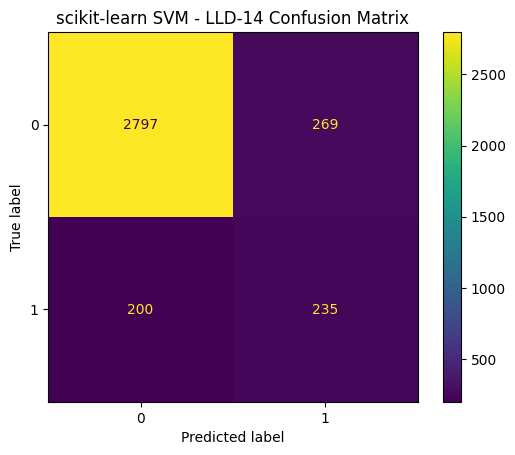



--- Evaluating: KNN on LLD-14 ---

-- scikit-learn KNN --
Accuracy on LLD-14: 0.8418
Prediction Duration: 0.0490 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      3066
           1       0.42      0.71      0.53       435

    accuracy                           0.84      3501
   macro avg       0.69      0.79      0.72      3501
weighted avg       0.89      0.84      0.86      3501

Confusion Matrix:
[[2638  428]
 [ 126  309]]


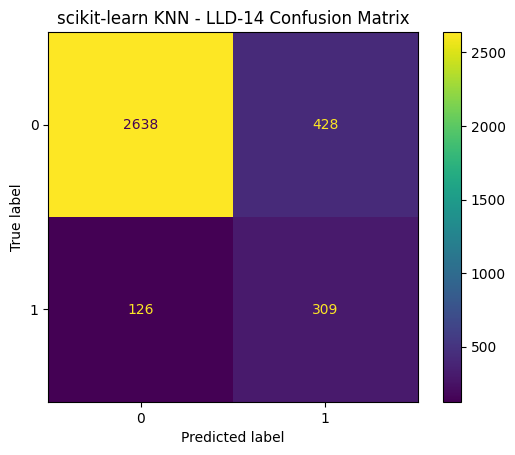



--- Evaluating: RF on LLD-14 ---

-- scikit-learn RF --
Accuracy on LLD-14: 0.9132
Prediction Duration: 0.0199 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3066
           1       0.65      0.65      0.65       435

    accuracy                           0.91      3501
   macro avg       0.80      0.80      0.80      3501
weighted avg       0.91      0.91      0.91      3501

Confusion Matrix:
[[2914  152]
 [ 152  283]]


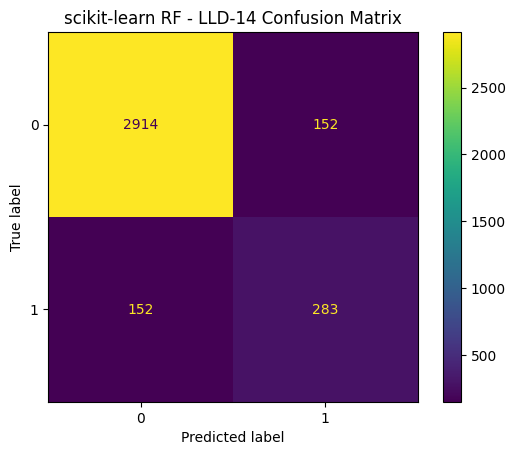



==================== LLA-2 EVALUATION ====================

--- Evaluating: SVM on LLA-2 ---

-- scikit-learn SVM --
Accuracy on LLA-2: 0.9184
Prediction Duration: 0.2242 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      5951
           1       0.05      0.01      0.02       413

    accuracy                           0.92      6364
   macro avg       0.49      0.50      0.49      6364
weighted avg       0.88      0.92      0.90      6364

Confusion Matrix:
[[5839  112]
 [ 407    6]]


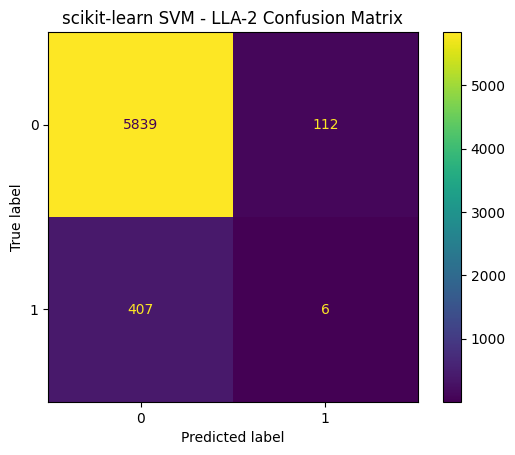



--- Evaluating: KNN on LLA-2 ---

-- scikit-learn KNN --
Accuracy on LLA-2: 0.9037
Prediction Duration: 0.0707 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5951
           1       0.14      0.09      0.11       413

    accuracy                           0.90      6364
   macro avg       0.54      0.52      0.53      6364
weighted avg       0.89      0.90      0.89      6364

Confusion Matrix:
[[5714  237]
 [ 376   37]]


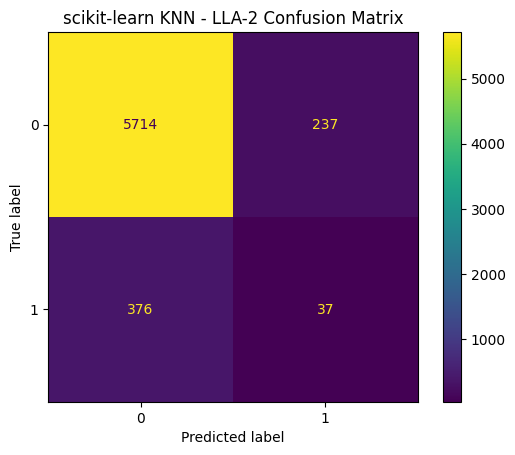



--- Evaluating: RF on LLA-2 ---

-- scikit-learn RF --
Accuracy on LLA-2: 0.9200
Prediction Duration: 0.0223 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5951
           1       0.11      0.03      0.05       413

    accuracy                           0.92      6364
   macro avg       0.52      0.51      0.50      6364
weighted avg       0.88      0.92      0.90      6364

Confusion Matrix:
[[5842  109]
 [ 400   13]]


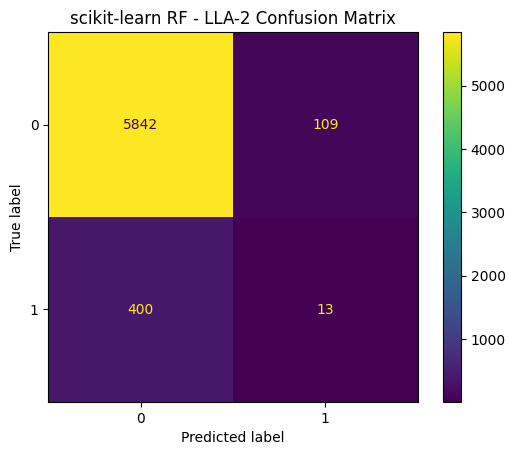



SUMMARY: LLB-10 trained models performance on all test wells

LLD-14 Results:
  scikit-learn Accuracies: {'SVM': 0.8660382747786347, 'KNN': 0.8417594972864896, 'RF': 0.913167666381034}
  scikit-learn Prediction Times: {'SVM': 0.15789151191711426, 'KNN': 0.04902315139770508, 'RF': 0.019887447357177734}

LLA-2 Results:
  scikit-learn Accuracies: {'SVM': 0.9184475172847266, 'KNN': 0.9036769327467001, 'RF': 0.9200188560653677}
  scikit-learn Prediction Times: {'SVM': 0.2241520881652832, 'KNN': 0.07065129280090332, 'RF': 0.02229142189025879}


In [42]:
# Evaluate LLB-10 trained models on all test wells data
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

print("Evaluating LLB-10 trained models on all test wells data...")
print("="*80)

for well_name_test in test_wells:
    print(f"\n{'='*20} {well_name_test} EVALUATION {'='*20}")
    
    # Initialize accuracy dictionaries for this well
    test_wells_sk_accuracy[well_name_test] = {}
    test_wells_cu_accuracy[well_name_test] = {}
    
    for model_name in sk_models.keys():
        print(f"\n--- Evaluating: {model_name} on {well_name_test} ---")
        
        # --- scikit-learn model evaluation ---
        if model_name in test_wells_sk_pred[well_name_test]:
            print(f"\n-- scikit-learn {model_name} --")
            
            # Calculate accuracy
            accuracy_sk = accuracy_score(test_wells_true_labels[well_name_test], test_wells_sk_pred[well_name_test][model_name])
            test_wells_sk_accuracy[well_name_test][model_name] = accuracy_sk
            print(f"Accuracy on {well_name_test}: {accuracy_sk:.4f}")
            
            # Prediction time
            print(f"Prediction Duration: {test_wells_sk_pred_times[well_name_test][model_name]:.4f} seconds")
            
            # Classification report
            print("Classification Report:")
            print(classification_report(test_wells_true_labels[well_name_test], test_wells_sk_pred[well_name_test][model_name]))
            
            # Confusion Matrix
            print("Confusion Matrix:")
            cm_sk = confusion_matrix(test_wells_true_labels[well_name_test], test_wells_sk_pred[well_name_test][model_name])
            print(cm_sk)
            
            # Plot confusion matrix
            disp_sk = ConfusionMatrixDisplay(confusion_matrix=cm_sk, display_labels=[0, 1])
            disp_sk.plot()
            plt.title(f"scikit-learn {model_name} - {well_name_test} Confusion Matrix")
            plt.show()
        
        # --- cuML model evaluation ---
        if has_cuml and model_name in test_wells_cu_pred[well_name_test]:
            print(f"\n-- cuML {model_name} --")
            
            # Calculate accuracy
            accuracy_cu = accuracy_score(test_wells_true_labels[well_name_test], test_wells_cu_pred[well_name_test][model_name])
            test_wells_cu_accuracy[well_name_test][model_name] = accuracy_cu
            print(f"Accuracy on {well_name_test}: {accuracy_cu:.4f}")
            
            # Prediction time
            print(f"Prediction Duration: {test_wells_cu_pred_times[well_name_test][model_name]:.4f} seconds")
            
            # Classification report
            print("Classification Report:")
            print(classification_report(test_wells_true_labels[well_name_test], test_wells_cu_pred[well_name_test][model_name]))
            
            # Confusion Matrix
            print("Confusion Matrix:")
            cm_cu = confusion_matrix(test_wells_true_labels[well_name_test], test_wells_cu_pred[well_name_test][model_name])
            print(cm_cu)
            
            # Plot confusion matrix
            disp_cu = ConfusionMatrixDisplay(confusion_matrix=cm_cu, display_labels=[0, 1])
            disp_cu.plot()
            plt.title(f"cuML {model_name} - {well_name_test} Confusion Matrix")
            plt.show()
        
        print("\n" + "="*40)

print("\n" + "="*80)
print("SUMMARY: LLB-10 trained models performance on all test wells")
print("="*80)
for well_name_test in test_wells:
    print(f"\n{well_name_test} Results:")
    print(f"  scikit-learn Accuracies: {test_wells_sk_accuracy[well_name_test]}")
    if has_cuml and test_wells_cu_accuracy[well_name_test]:
        print(f"  cuML Accuracies: {test_wells_cu_accuracy[well_name_test]}")
    print(f"  scikit-learn Prediction Times: {test_wells_sk_pred_times[well_name_test]}")
    if has_cuml and test_wells_cu_pred_times[well_name_test]:
        print(f"  cuML Prediction Times: {test_wells_cu_pred_times[well_name_test]}")


==================== LLD-14 VISUALIZATION ====================


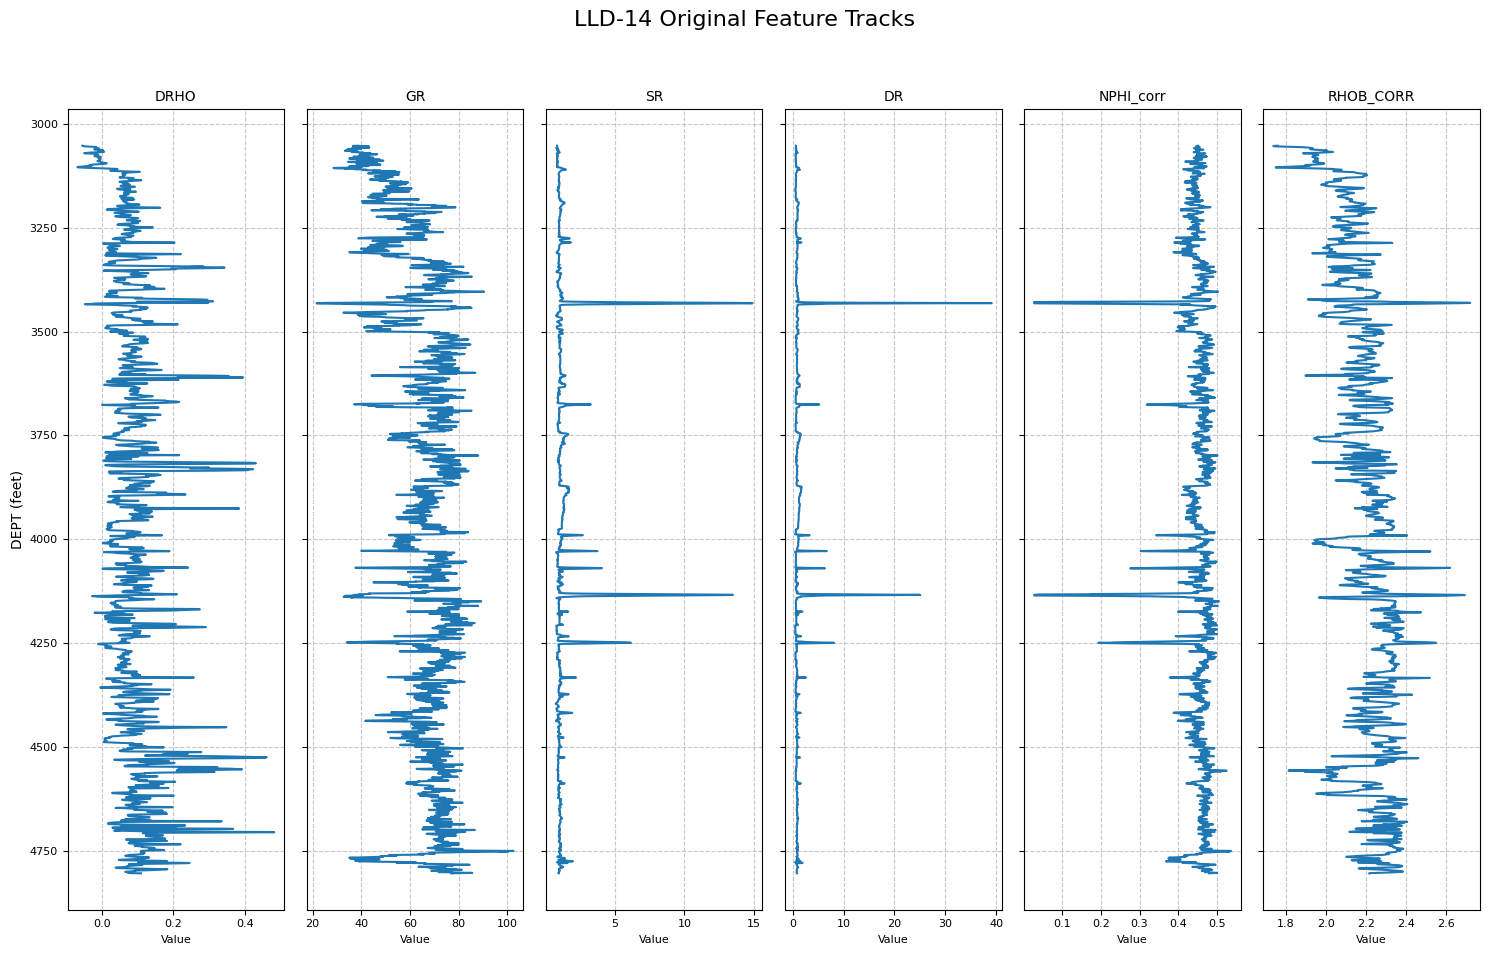

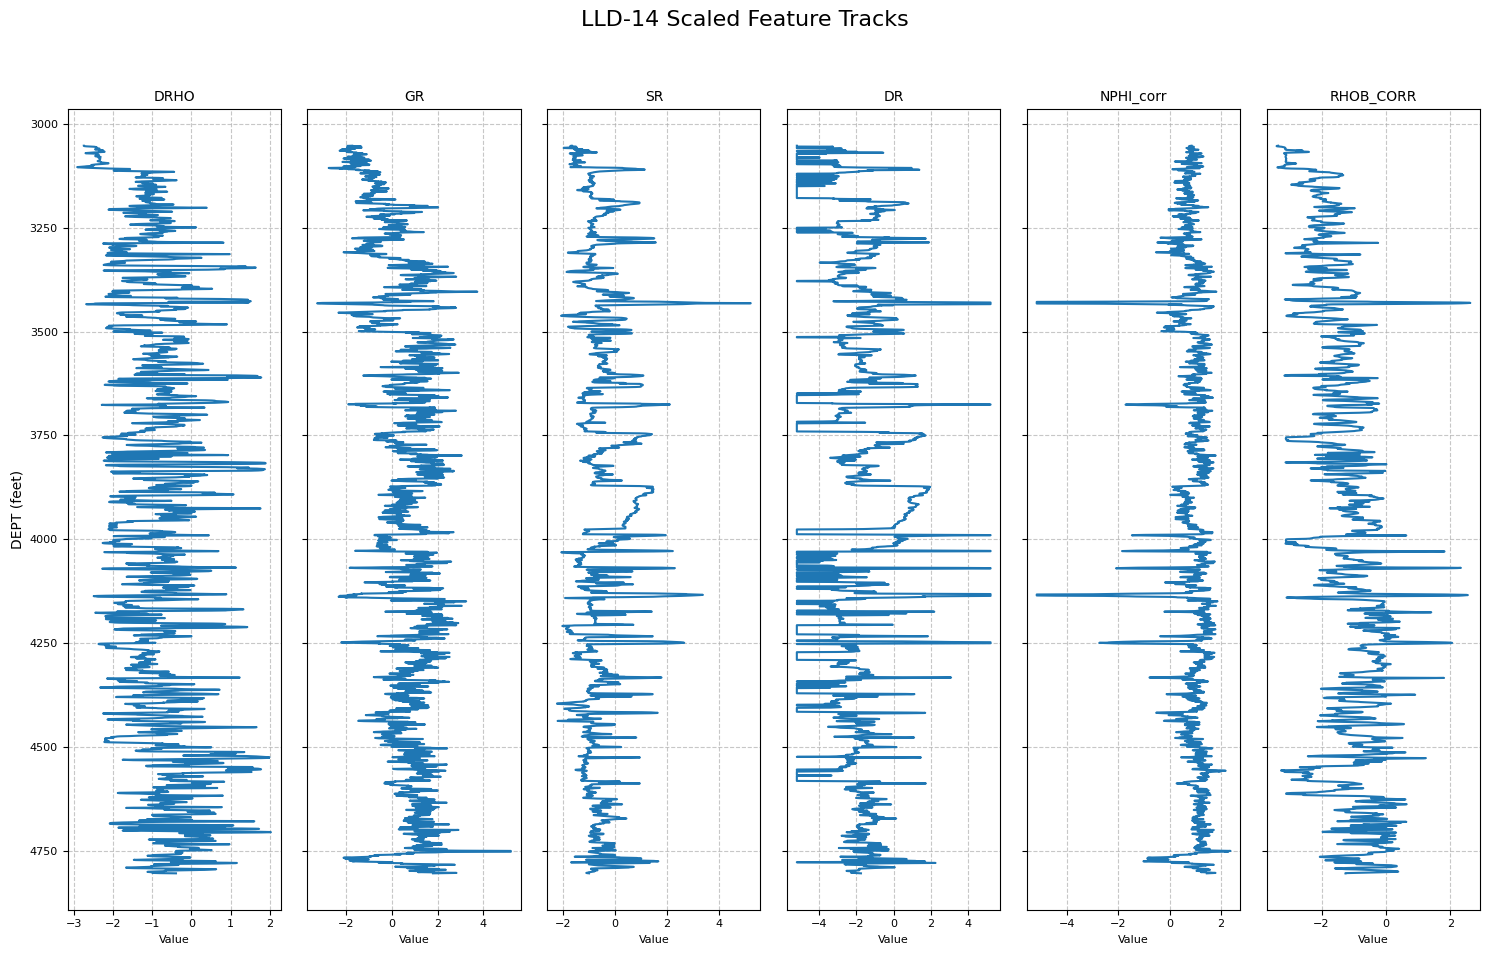

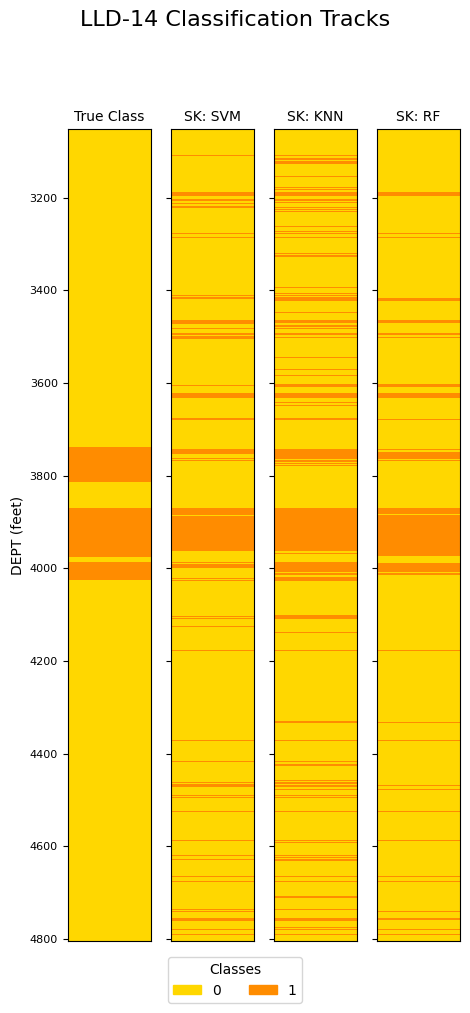


==================== LLA-2 VISUALIZATION ====================


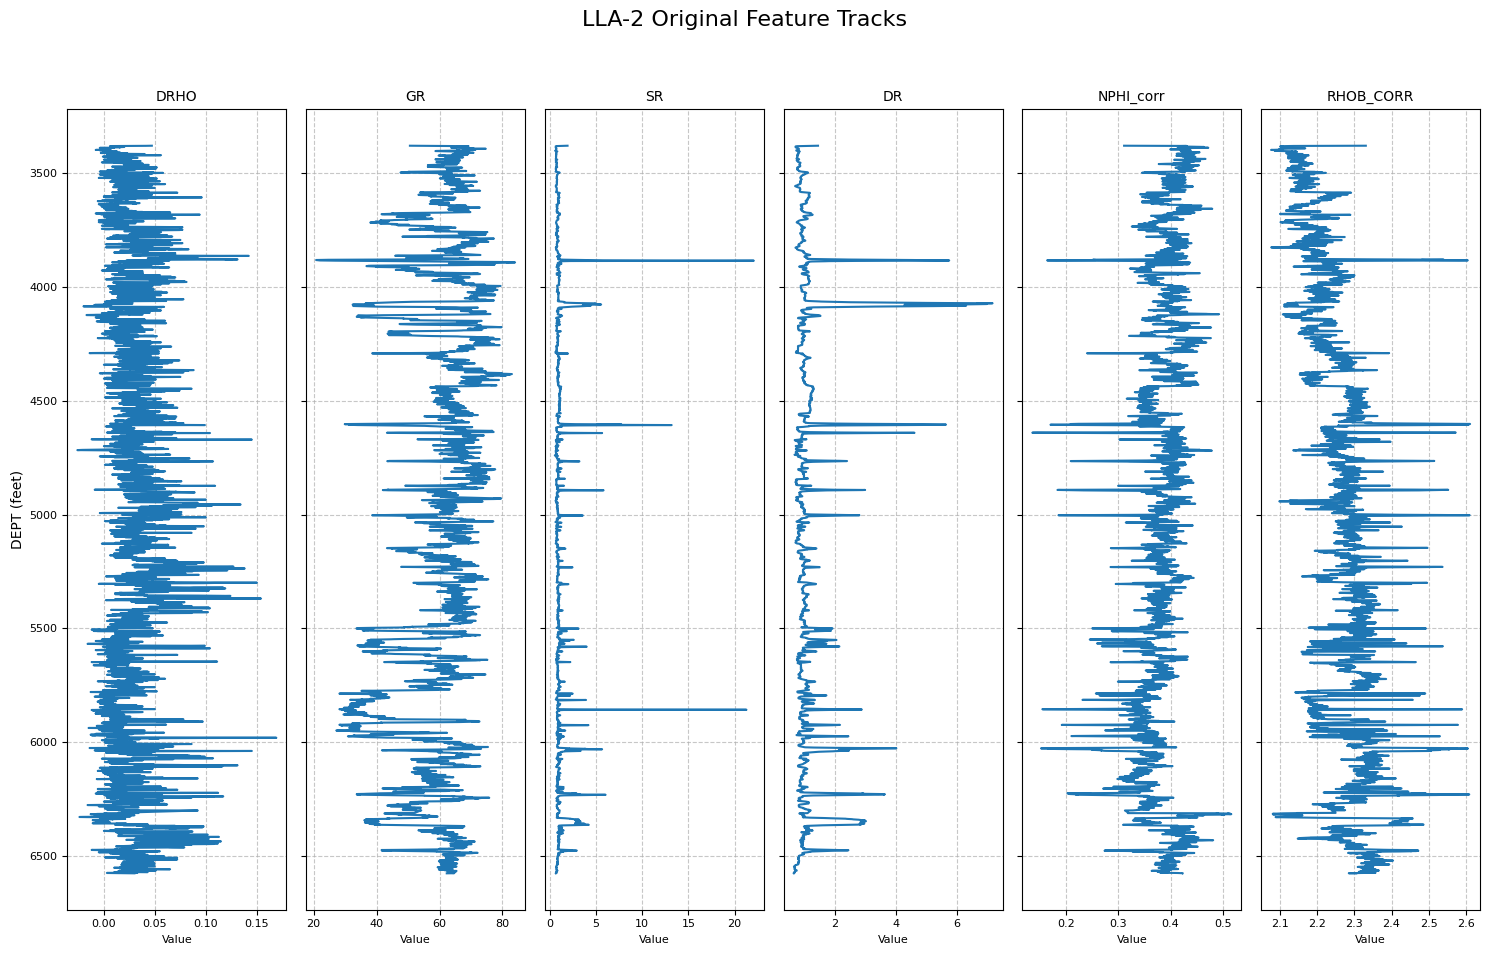

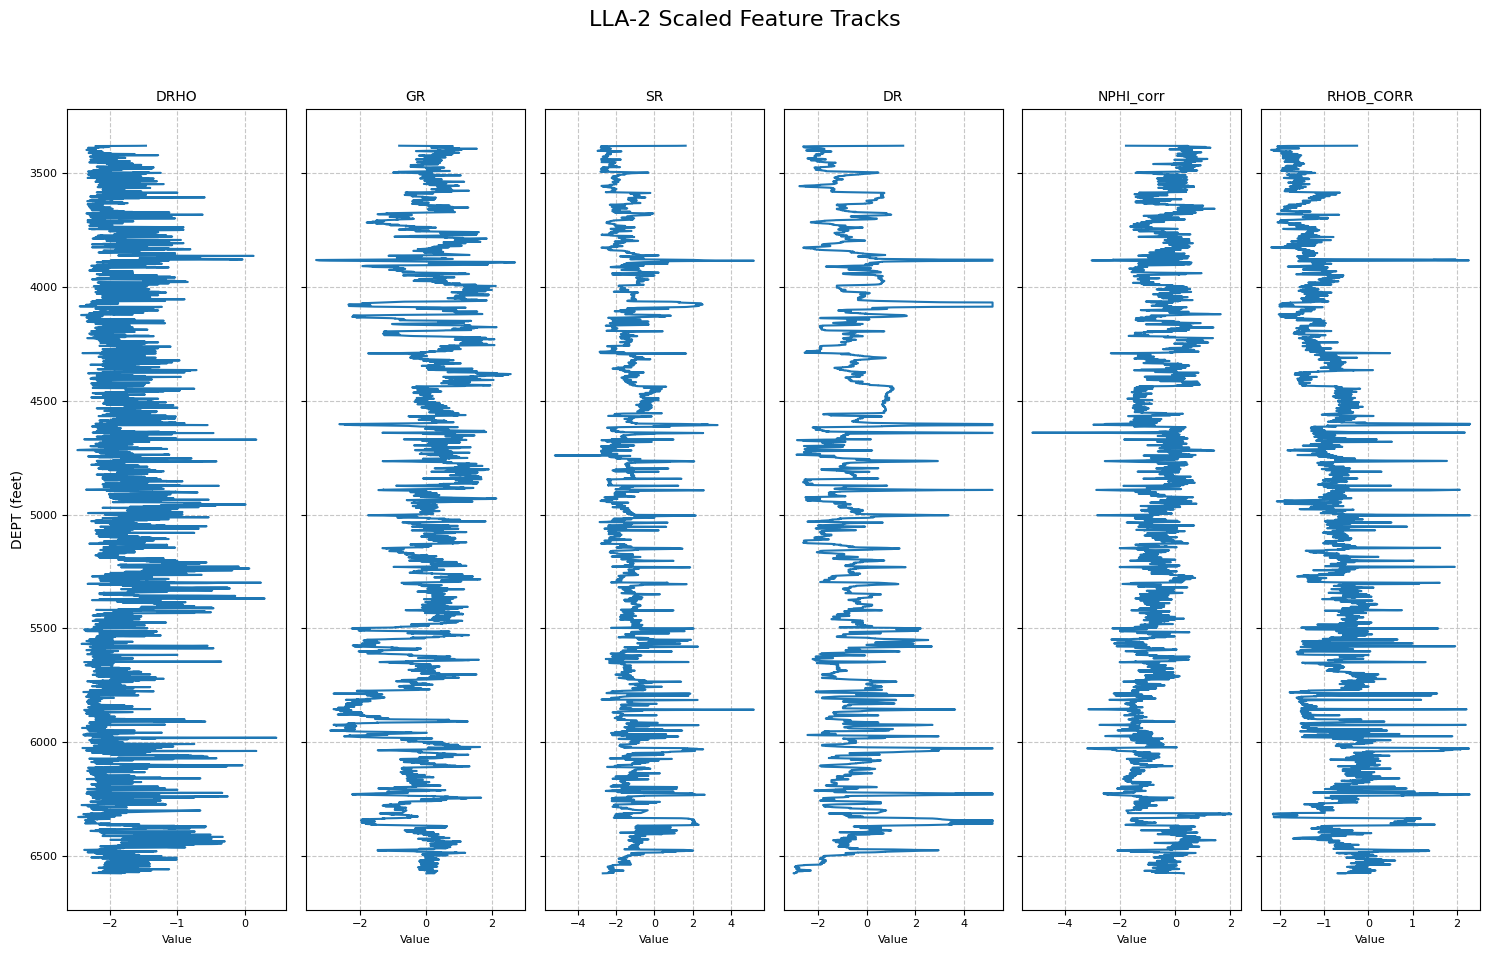

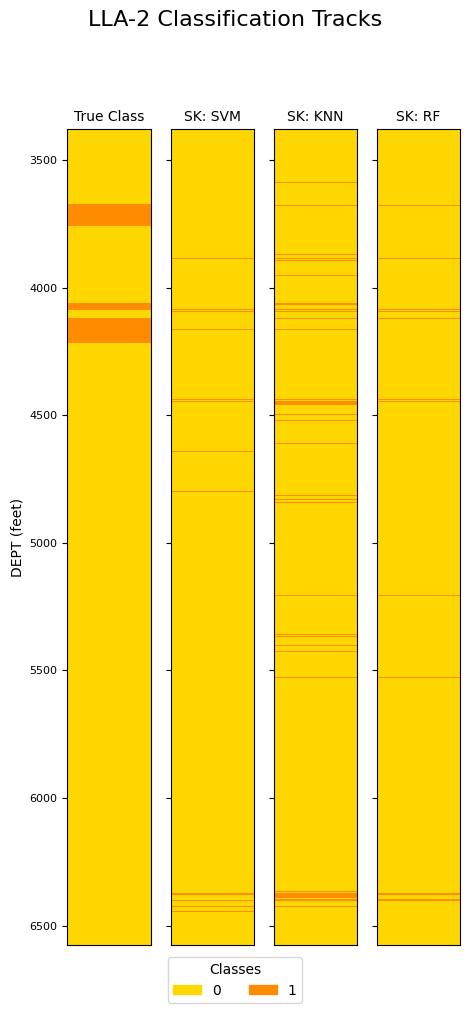

In [43]:
# Create visualization plots for all test wells data and predictions
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

for well_name_test in test_wells:
    print(f"\n{'='*20} {well_name_test} VISUALIZATION {'='*20}")
    
    if 'DEPT' not in test_wells_data[well_name_test].columns:
        print(f"Error: 'DEPT' column not found in {well_name_test} data DataFrame. Cannot generate depth plots.")
        continue
    
    depth_column_test = test_wells_data[well_name_test]['DEPT']
    feature_names = test_wells_features[well_name_test].columns.tolist()

    # Prepare labels and predictions for this test well
    true_labels_test = test_wells_true_labels[well_name_test]
    all_predictions_test_to_plot = {}
    all_predictions_test_to_plot['True Labels'] = true_labels_test
    
    # Add scikit-learn predictions
    for model_name, preds in test_wells_sk_pred[well_name_test].items():
        all_predictions_test_to_plot[f'SK: {model_name}'] = preds
    
    # Add cuML predictions if available
    if has_cuml and test_wells_cu_pred[well_name_test]:
        for model_name, preds_cu in test_wells_cu_pred[well_name_test].items():
            all_predictions_test_to_plot[f'CU: {model_name}'] = preds_cu

    # Define colors for classes
    if isinstance(true_labels_test, np.ndarray):
        unique_classes = np.sort(np.unique(true_labels_test))
    else:
        unique_classes = np.sort(true_labels_test.unique())

    if len(unique_classes) == 1:
        plot_colors = ['gold']
    elif len(unique_classes) == 2:
        plot_colors = ['gold', 'darkorange']
    else:
        cmap_tab10 = plt.cm.get_cmap('tab10', len(unique_classes))
        plot_colors = [mcolors.to_hex(cmap_tab10(i)) for i in range(len(unique_classes))]

    class_to_int = {cls: i for i, cls in enumerate(unique_classes)}
    cmap_listed = mcolors.ListedColormap(plot_colors[:len(unique_classes)])

    # --- Figure 1: Original Feature Tracks ---
    num_feature_plots = len(feature_names)
    if num_feature_plots > 0:
        fig_features, axes_features = plt.subplots(1, num_feature_plots, figsize=(num_feature_plots * 2.5, 10), sharey=True)
        if num_feature_plots == 1:
            axes_features = [axes_features]
        fig_features.suptitle(f"{well_name_test} Original Feature Tracks", fontsize=16, y=0.98)

        for i, feature_name in enumerate(feature_names):
            ax = axes_features[i]
            ax.plot(test_wells_data[well_name_test][feature_name], depth_column_test)
            ax.set_title(feature_name, fontsize=10)
            ax.set_xlabel("Value", fontsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        axes_features[0].invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # --- Figure 2: Scaled Feature Tracks ---
    if num_feature_plots > 0:
        fig_features_scaled, axes_features_scaled = plt.subplots(1, num_feature_plots, figsize=(num_feature_plots * 2.5, 10), sharey=True)
        if num_feature_plots == 1:
            axes_features_scaled = [axes_features_scaled]
        fig_features_scaled.suptitle(f"{well_name_test} Scaled Feature Tracks", fontsize=16, y=0.98)

        for i, feature_name in enumerate(feature_names):
            ax = axes_features_scaled[i]
            ax.plot(test_wells_features_scaled[well_name_test][feature_name], depth_column_test)
            ax.set_title(feature_name, fontsize=10)
            ax.set_xlabel("Value", fontsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)

        axes_features_scaled[0].invert_yaxis()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # --- Figure 3: Classification Tracks ---
    num_classification_plots = len(all_predictions_test_to_plot)
    if num_classification_plots > 0:
        fig_class, axes_class = plt.subplots(1, num_classification_plots, figsize=(num_classification_plots * 1.2, 10), sharey=True)
        if num_classification_plots == 1: # Handle single classification plot case
            axes_class = [axes_class]
        fig_class.suptitle(f"{well_name_test} Classification Tracks", fontsize=16, y=0.98)

        plot_order = ['True Labels'] + [k for k in all_predictions_test_to_plot.keys() if k != 'True Labels']

        for i, title in enumerate(plot_order):
            predictions_data = all_predictions_test_to_plot[title]
            ax = axes_class[i]

            if isinstance(predictions_data, pd.Series):
                mapped_preds = predictions_data.map(class_to_int).fillna(-1)
            elif isinstance(predictions_data, np.ndarray):
                temp_series = pd.Series(predictions_data, index=test_wells_features_scaled[well_name_test].index)
                mapped_preds = temp_series.map(class_to_int).fillna(-1)
            else:
                print(f"Warning: Data for {title} is of unexpected type: {type(predictions_data)}")
                continue

            labels_int = mapped_preds.values.reshape(-1, 1)
            vmin = 0
            vmax = len(plot_colors) - 1

            ax.imshow(labels_int, aspect='auto', cmap=cmap_listed,
                      extent=[0, 1, depth_column_test.max(), depth_column_test.min()],
                      interpolation='none', vmin=vmin, vmax=vmax)

            if title == 'True Labels':
                ax.set_title("True Class", fontsize=10)
            else:
                ax.set_title(title, fontsize=10)

            ax.set_xticks([])
            ax.set_xlabel("")
            ax.tick_params(axis='y', labelsize=8)
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)

        # axes_class[0].invert_yaxis()

        if unique_classes is not None and len(unique_classes) > 0:
            patches = [plt.Rectangle((0,0),1,1, color=plot_colors[class_to_int[cls]]) for cls in unique_classes]
            legend_labels = [str(cls) for cls in unique_classes]
            fig_class.legend(patches, legend_labels, loc='lower center', ncol=len(unique_classes), bbox_to_anchor=(0.5, -0.02), title="Classes")

        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()
    else:
        print(f"No classification data to plot for {well_name_test}.")

In [44]:
# Create a comprehensive comparison summary between LLB-10 and all test wells performance
import pandas as pd
import matplotlib.pyplot as plt

print("="*80)
print("COMPREHENSIVE PERFORMANCE COMPARISON: LLB-10 vs ALL TEST WELLS")
print("="*80)

# --- Accuracy Comparison ---
print("\n1. ACCURACY COMPARISON")
print("-" * 40)

comparison_data = []
for model_name in sk_models.keys():
    # scikit-learn comparison
    row_sk = {
        'Model': f'SK-{model_name}',
        'LLB-10_Train': sk_train_accuracy.get(model_name, 'N/A'),
        'LLB-10_Test': sk_test_accuracy.get(model_name, 'N/A'),
        'LLB-10_CV': sk_crossValidation_accuracy.get(model_name, 'N/A')
    }
    
    # Add test wells accuracy columns
    for well_name_test in test_wells:
        row_sk[f'{well_name_test}_Test'] = test_wells_sk_accuracy[well_name_test].get(model_name, 'N/A')
    
    comparison_data.append(row_sk)
    
    # cuML comparison if available
    if has_cuml and model_name in cu_train_accuracy:
        row_cu = {
            'Model': f'CU-{model_name}',
            'LLB-10_Train': cu_train_accuracy.get(model_name, 'N/A'),
            'LLB-10_Test': cu_test_accuracy.get(model_name, 'N/A'),
            'LLB-10_CV': cu_crossValidation_accuracy.get(f"cu_{model_name}", 'N/A')
        }
        
        # Add test wells accuracy columns
        for well_name_test in test_wells:
            row_cu[f'{well_name_test}_Test'] = test_wells_cu_accuracy[well_name_test].get(model_name, 'N/A')
        
        comparison_data.append(row_cu)

accuracy_df = pd.DataFrame(comparison_data)
print("\nAccuracy Comparison Table:")
print(accuracy_df.to_string(index=False))

# --- Timing Comparison ---
print("\n\n2. TIMING COMPARISON")
print("-" * 40)

timing_data = []
for model_name in sk_models.keys():
    # scikit-learn timing
    row_sk = {
        'Model': f'SK-{model_name}',
        'Training_Time(s)': sk_times.get(model_name, 'N/A'),
        'LLB-10_Pred_Time(s)': sk_pred_times.get(model_name, 'N/A')
    }
    
    # Add test wells prediction time columns
    for well_name_test in test_wells:
        row_sk[f'{well_name_test}_Pred_Time(s)'] = test_wells_sk_pred_times[well_name_test].get(model_name, 'N/A')
    
    timing_data.append(row_sk)
    
    # cuML timing if available
    if has_cuml and model_name in cu_times:
        row_cu = {
            'Model': f'CU-{model_name}',
            'Training_Time(s)': cu_times.get(model_name, 'N/A'),
            'LLB-10_Pred_Time(s)': cu_pred_times.get(model_name, 'N/A')
        }
        
        # Add test wells prediction time columns
        for well_name_test in test_wells:
            row_cu[f'{well_name_test}_Pred_Time(s)'] = test_wells_cu_pred_times[well_name_test].get(model_name, 'N/A')
        
        timing_data.append(row_cu)

timing_df = pd.DataFrame(timing_data)
print("\nTiming Comparison Table:")
print(timing_df.to_string(index=False))

# --- Generalization Analysis ---
print("\n\n3. GENERALIZATION ANALYSIS")
print("-" * 40)

for well_name_test in test_wells:
    print(f"\n--- Generalization to {well_name_test} ---")
    generalization_data = []
    
    for model_name in sk_models.keys():
        # scikit-learn generalization
        if (model_name in sk_test_accuracy and model_name in test_wells_sk_accuracy[well_name_test] and 
            sk_test_accuracy[model_name] != 'N/A' and test_wells_sk_accuracy[well_name_test][model_name] != 'N/A'):
            
            llb10_test_acc = sk_test_accuracy[model_name]
            test_well_acc = test_wells_sk_accuracy[well_name_test][model_name]
            generalization_drop = llb10_test_acc - test_well_acc
            
            row_sk = {
                'Model': f'SK-{model_name}',
                'LLB-10_Test_Acc': f"{llb10_test_acc:.4f}",
                f'{well_name_test}_Test_Acc': f"{test_well_acc:.4f}",
                'Generalization_Drop': f"{generalization_drop:.4f}",
                'Drop_Percentage': f"{(generalization_drop/llb10_test_acc)*100:.2f}%"
            }
            generalization_data.append(row_sk)
        
        # cuML generalization if available
        if (has_cuml and model_name in cu_test_accuracy and model_name in test_wells_cu_accuracy[well_name_test] and
            cu_test_accuracy[model_name] != 'N/A' and test_wells_cu_accuracy[well_name_test][model_name] != 'N/A'):
            
            llb10_test_acc = cu_test_accuracy[model_name]
            test_well_acc = test_wells_cu_accuracy[well_name_test][model_name]
            generalization_drop = llb10_test_acc - test_well_acc
            
            row_cu = {
                'Model': f'CU-{model_name}',
                'LLB-10_Test_Acc': f"{llb10_test_acc:.4f}",
                f'{well_name_test}_Test_Acc': f"{test_well_acc:.4f}",
                'Generalization_Drop': f"{generalization_drop:.4f}",
                'Drop_Percentage': f"{(generalization_drop/llb10_test_acc)*100:.2f}%"
            }
            generalization_data.append(row_cu)

    if generalization_data:
        generalization_df = pd.DataFrame(generalization_data)
        print(f"\nGeneralization Analysis Table for {well_name_test}:")
        print(generalization_df.to_string(index=False))
    else:
        print(f"No generalization data available for analysis for {well_name_test}.")

print("\n\nKEY INSIGHTS:")
print("- Positive 'Generalization_Drop' indicates performance degradation on test wells")
print("- Negative 'Generalization_Drop' indicates better performance on test wells")
print("- Lower 'Drop_Percentage' indicates better generalization capability")

print("\n" + "="*80)

COMPREHENSIVE PERFORMANCE COMPARISON: LLB-10 vs ALL TEST WELLS

1. ACCURACY COMPARISON
----------------------------------------

Accuracy Comparison Table:
 Model  LLB-10_Train  LLB-10_Test  LLB-10_CV  LLD-14_Test  LLA-2_Test
SK-SVM      0.976812     0.947257   0.971086     0.866038    0.918448
SK-KNN      1.000000     0.943741   0.969302     0.841759    0.903677
 SK-RF      0.999531     0.963432   0.979535     0.913168    0.920019


2. TIMING COMPARISON
----------------------------------------

Timing Comparison Table:
 Model  Training_Time(s)  LLB-10_Pred_Time(s)  LLD-14_Pred_Time(s)  LLA-2_Pred_Time(s)
SK-SVM          4.375248             0.249837             0.157892            0.224152
SK-KNN          0.621717             0.064431             0.049023            0.070651
 SK-RF         22.021403             0.039753             0.019887            0.022291


3. GENERALIZATION ANALYSIS
----------------------------------------

--- Generalization to LLD-14 ---

Generalization Analys

# Layer by layer Hydrocarbon analysis


This section segregates the machine learning results for a well based on the predefined `layer_boundaries`. For each layer, it calculates the percentage of data points classified as hydrocarbon-positive (class 1). A layer is designated as 'Hydrocarbon' if this percentage is greater than `hydrocarbon_percentage_threshold`, and 'Non-Hydrocarbon' otherwise.


In [45]:
hydrocarbon_percentage_threshold = 25

## Layer boundaries

In [46]:
layer_boundaries = {}
layer_boundaries['LLB-10'] = [
    2199,
    2249,
    2556,
    2693,
    2726,
    2871,
    2886,
    2957,
    2978,
    3052,
    3078,
    3155,
    3197,
    3399,
    3408,
    3568,
    3644,
    3658,
    3738,
    3772,
    3811,
    3873,
    3937,
    3957,
    3969,
    4005,
    4183,
    4198,
    4204,
    4217,
    4321,
    4410,
    4497,
    4632,
    4643,
    4697,
    4875,
    4891,
    4915,
    4928,
    5031,
    5041,
    5124,
    5144,
    5170,
    5190,
    5309,
    5384,
    5444,
    5468,
    5734,
    5764,
    5791,
    5839,
    5901,
    5951,
    6073,
    6095,
    6102,
    6123,
    6137,
    6323,
    6421,
    6683,
    6720,
    6976,
    7148,
    7362,
    7529,
    7547,
    7554,
    8736,
    8779,
    8854,
    8873,
    9049,
    9166,
    9228,
    9233,
    9282,
    9284,
    9290,
    9372,
    9399,
    9420,
    9432,
    9441,
    9463,
    9475,
    9483,
    9504,
    9547,
    9558,
    9625,
    9671,
    9685,
    9734,
    9740,
    9802,
    9828,
    9838,
    9870,
    9881,
    9892,
    9914,
    9926,
    9970,
    10019,
    10123,
    10151,
    10185,
    10237,
    10242,
    10245,
    10349,
    10381,
    10394,
    10429,
    10480,
    10505,
    10534,
    10543,
    10571,
    10578,
    10583
]
layer_boundaries['LLA-2'] = [
    3380,
    3493,
    3509,
    3583,
    3603,
    3674,
    3758,
    3859,
    3888,
    3903,
    3957,
    4063,
    4089,
    4123,
    4218,
    4290,
    4366,
    4433,
    4556,
    4566,
    4613,
    4753,
    4769,
    4793,
    4799,
    4887,
    4895,
    4997,
    5019,
    5031,
    5047,
    5142,
    5205,
    5231,
    5257,
    5490,
    5512,
    5540,
    5617,
    5639,
    5659,
    5682,
    5687,
    5724,
    5765,
    5772,
    5901,
    5911,
    5980,
    6030,
    6207,
    6215,
    6367,
    6470,
    6484,
    6576,
    6585,
    6622,
    6631,
    6636,
    6727,
    6782
]
layer_boundaries['LLD-14'] = [
    1908,
    1968,
    2166,
    2284,
    2310,
    2418,
    2434,
    2489,
    2505,
    2542,
    2569,
    2657,
    2663,
    2803,
    2881,
    3009,
    3100,
    3114,
    3184,
    3210,
    3274,
    3324,
    3407,
    3439,
    3448,
    3483,
    3602,
    3637,
    3642,
    3684,
    3740,
    3814,
    3872,
    3976,
    3988,
    4026,
    4131,
    4143,
    4173,
    4176,
    4204,
    4208,
    4243,
    4254,
    4265,
    4272,
    4414,
    4480,
    4582,
    4598,
    4754,
    4782,
    4804,
    4862,
    4871,
    4928,
    4932,
    4995,
    5028,
    5077,
    5085,
    5206,
    5230,
    5303,
    5385,
    5538,
    5559,
    5894,
    5940,
    6015,
    6089,
    6106,
    6175,
    6487,
    6766,
    7046,
    7089,
    7155,
    7240,
    7337,
    7458,
    7521,
    7563,
    7566,
    7630,
    7646,
    7650,
    7657,
    7663,
    7666,
    7690,
    7716,
    7729,
    7762,
    7807,
    7839,
    7851,
    7886,
    7898,
    7956,
    7976,
    7993,
    8018,
    8066,
    8072,
    8083,
    8106,
    8130,
    8139,
    8227,
    8266,
    8287
]

## End of layer boundaries

In [47]:
# Modular functions for layer-by-layer analysis

def prepare_results_dataframe(data_df, true_labels, sk_predictions, cu_predictions=None, has_cuml=False):
    """
    Prepare a combined dataframe with depth, true labels, and all predictions.
    
    Args:
        data_df: DataFrame with DEPT column
        true_labels: True labels/classes
        sk_predictions: Dictionary of scikit-learn predictions
        cu_predictions: Dictionary of cuML predictions (optional)
        has_cuml: Boolean indicating if cuML is available
    
    Returns:
        DataFrame with all combined data
    """
    results_df = data_df[['DEPT']].copy()
    results_df['True_Labels'] = true_labels
    
    # Add scikit-learn predictions
    for model_name, preds in sk_predictions.items():
        results_df[f'SK_{model_name}'] = preds
    
    # Add cuML predictions if available
    if has_cuml and cu_predictions:
        for model_name, preds in cu_predictions.items():
            # Ensure predictions are in a compatible format
            if hasattr(preds, 'get'):
                results_df[f'CU_{model_name}'] = preds.get()
            else:
                results_df[f'CU_{model_name}'] = preds
    
    return results_df

def analyze_layers(results_df, boundaries, threshold):
    """
    Analyze hydrocarbon percentage for each layer.
    
    Args:
        results_df: DataFrame with DEPT and prediction columns
        boundaries: List of layer boundary depths
        threshold: Hydrocarbon percentage threshold for classification
    
    Returns:
        DataFrame with layer analysis results
    """
    layer_analysis_results = []
    
    for i in range(len(boundaries) - 1):
        start_depth = boundaries[i]
        end_depth = boundaries[i+1]
        
        # Filter data for the current layer
        layer_data = results_df[(results_df['DEPT'] >= start_depth) & (results_df['DEPT'] < end_depth)]
        
        if not layer_data.empty:
            layer_info = {
                'Layer': f"{i+1}",
                'Start_Depth': start_depth,
                'End_Depth': end_depth
            }
            
            # Analyze each prediction column
            for col in results_df.columns:
                if col not in ['DEPT']:
                    hydrocarbon_percentage = layer_data[col].mean() * 100
                    classification = 'Hydrocarbon' if hydrocarbon_percentage > threshold else 'Non-Hydrocarbon'
                    layer_info[f'{col}_HC_%'] = f"{hydrocarbon_percentage:.2f}%"
                    layer_info[f'{col}_Class'] = classification
            
            layer_analysis_results.append(layer_info)
    
    return pd.DataFrame(layer_analysis_results)

def analyze_well_layers(well_name, data_df, true_labels, sk_predictions, cu_predictions, boundaries, threshold, has_cuml=False):
    """
    Complete layer analysis for a single well.
    
    Args:
        well_name: Name of the well (e.g., 'LLB-10', 'LLD-14')
        data_df: DataFrame with DEPT column
        true_labels: True labels/classes
        sk_predictions: Dictionary of scikit-learn predictions
        cu_predictions: Dictionary of cuML predictions
        boundaries: List of layer boundary depths for this well
        threshold: Hydrocarbon percentage threshold for classification
        has_cuml: Boolean indicating if cuML is available
    
    Returns:
        DataFrame with layer analysis results
    """
    results_df = prepare_results_dataframe(data_df, true_labels, sk_predictions, cu_predictions, has_cuml)
    layer_summary = analyze_layers(results_df, boundaries, threshold)
    return layer_summary

def plot_layer_classification_for_well(layer_summary_results, well_name):
    """
    Create visualization for layer-by-layer classification for a specific well.
    
    Args:
        layer_summary_results: Dictionary containing layer analysis results for all wells
        well_name: Name of the well to plot
    """
    if well_name not in layer_summary_results:
        print(f"No layer analysis data found for {well_name}")
        return
    
    layer_summary_df = layer_summary_results[well_name]
    
    # Get the list of classification columns to plot
    class_cols = [col for col in layer_summary_df.columns if col.endswith('_Class')]
    
    # Define colors for the plot
    color_map = {'Non-Hydrocarbon': 'gold', 'Hydrocarbon': 'darkorange'}
    
    num_plots = len(class_cols)
    if num_plots > 0:
        fig, axes = plt.subplots(1, num_plots, figsize=(num_plots * 1.2, 10), sharey=True)
        if num_plots == 1:
            axes = [axes]
        fig.suptitle(f'{well_name} Layer-by-Layer Aggregated Classification', fontsize=16, y=0.98)
        
        for i, col_name in enumerate(class_cols):
            ax = axes[i]
            
            # Iterate over each layer in the summary dataframe
            for idx, row in layer_summary_df.iterrows():
                start_depth = row['Start_Depth']
                end_depth = row['End_Depth']
                classification = row[col_name]
                
                # Get the color for the classification
                color = color_map.get(classification, 'white')
                
                # Draw a colored block for the layer
                ax.axhspan(start_depth, end_depth, color=color, alpha=1)
            
            # Formatting the plot
            model_title = col_name.replace('_Class', '').replace('_', ' ')
            ax.set_title(model_title, fontsize=10)
            ax.set_xticks([])
            ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)
            
            if i == 0:
                ax.set_ylabel("DEPT (feet)", fontsize=10)
            
            # Set depth limits based on the full range of layers
            ax.set_ylim(layer_summary_df['End_Depth'].max(), layer_summary_df['Start_Depth'].min())
        
        # Create a legend
        patches = [plt.Rectangle((0,0),1,1, color=color_map[cls]) for cls in color_map]
        legend_labels = list(color_map.keys())
        fig.legend(patches, legend_labels, loc='lower center', ncol=len(legend_labels), 
                  bbox_to_anchor=(0.5, -0.02), title="Layer Classification")
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print(f"No layer classification summary data to plot for {well_name}.")

def calculate_all_layer_accuracies(layer_summary_results):
    """
    Calculate layer-level accuracy for each model across all wells.
    
    Args:
        layer_summary_results: Dictionary containing layer analysis results for all wells
    
    Returns:
        Dictionary with well names as keys and model accuracies as values
    """
    all_accuracies = {}
    
    for well_name, layer_summary_df in layer_summary_results.items():
        true_layer_classes = layer_summary_df['True_Labels_Class']
        pred_class_cols = [col for col in layer_summary_df.columns 
                          if col.endswith('_Class') and col != 'True_Labels_Class']
        
        well_accuracies = {}
        for col in pred_class_cols:
            pred_layer_classes = layer_summary_df[col]
            accuracy = accuracy_score(true_layer_classes, pred_layer_classes)
            model_key = col.replace('_Class', '')
            well_accuracies[model_key] = accuracy
        
        all_accuracies[well_name] = well_accuracies
    
    return all_accuracies

def print_comprehensive_layer_accuracy_analysis(all_layer_accuracies):
    """
    Print comprehensive layer accuracy analysis for all wells.
    
    Args:
        all_layer_accuracies: Dictionary with well names as keys and model accuracies as values
    """
    print("LAYER-LEVEL ACCURACY ANALYSIS")
    print("="*60)
    
    # Print individual well accuracies
    for well_name, accuracies in all_layer_accuracies.items():
        print(f"\n{well_name} Layer-Level Accuracy:")
        print("-" * 30)
        for model_key, accuracy in accuracies.items():
            print(f"{model_key}: {accuracy:.4f}")
    
    # Create summary comparison if we have both wells
    well_names = list(all_layer_accuracies.keys())
    if len(well_names) >= 2:
        print("\n" + "="*60)
        print("LAYER-LEVEL ACCURACY COMPARISON SUMMARY")
        print("="*60)
        
        # Get all unique model keys
        all_model_keys = set()
        for accuracies in all_layer_accuracies.values():
            all_model_keys.update(accuracies.keys())
        
        summary_data = []
        for model_key in sorted(all_model_keys):
            row = {'Model': model_key}
            for well_name in well_names:
                if model_key in all_layer_accuracies[well_name]:
                    row[f'{well_name} Layer Accuracy'] = all_layer_accuracies[well_name][model_key]
                else:
                    row[f'{well_name} Layer Accuracy'] = 'N/A'
            summary_data.append(row)
        
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))
        
        # Calculate generalization gap at layer level
        if len(well_names) == 2:
            well1, well2 = well_names[0], well_names[1]
            print(f"\nLayer-Level Generalization Analysis ({well1} vs {well2}):")
            print("-" * 40)
            for model_key in sorted(all_model_keys):
                if (model_key in all_layer_accuracies[well1] and 
                    model_key in all_layer_accuracies[well2]):
                    acc1 = all_layer_accuracies[well1][model_key]
                    acc2 = all_layer_accuracies[well2][model_key]
                    gap = acc1 - acc2
                    print(f"{model_key}: {gap:+.4f} ({'better' if gap < 0 else 'worse'} on {well2})")

## LLB-10

In [48]:
# Initialize layer summary results object
layer_summary_results = {}

# Analyze LLB-10 layers using modular functions
layer_summary_results['LLB-10'] = analyze_well_layers(
    well_name='LLB-10',
    data_df=data,
    true_labels=y,
    sk_predictions=sk_pred,
    cu_predictions=cu_pred,
    boundaries=layer_boundaries['LLB-10'],
    threshold=hydrocarbon_percentage_threshold,
    has_cuml=has_cuml
)

# Display the summary table
print(f"LLB-10 Layer-by-Layer Hydrocarbon Classification Summary (Threshold > {hydrocarbon_percentage_threshold}%):")
display(layer_summary_results['LLB-10'])

LLB-10 Layer-by-Layer Hydrocarbon Classification Summary (Threshold > 25%):


,Layer,Start_Depth,End_Depth,True_Labels_HC_%,True_Labels_Class,SK_SVM_HC_%,SK_SVM_Class,SK_KNN_HC_%,SK_KNN_Class,SK_RF_HC_%,SK_RF_Class
0,18,3658,3738,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
1,19,3738,3772,0.00%,Non-Hydrocarbon,14.71%,Non-Hydrocarbon,1.47%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
2,20,3772,3811,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
3,21,3811,3873,0.00%,Non-Hydrocarbon,1.06%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
4,22,3873,3937,0.00%,Non-Hydrocarbon,4.76%,Non-Hydrocarbon,1.90%,Non-Hydrocarbon,0.95%,Non-Hydrocarbon
5,23,3937,3957,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,2.50%,Non-Hydrocarbon,2.50%,Non-Hydrocarbon
6,24,3957,3969,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
7,25,3969,4005,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
8,26,4005,4183,0.00%,Non-Hydrocarbon,7.30%,Non-Hydrocarbon,2.53%,Non-Hydrocarbon,0.56%,Non-Hydrocarbon
9,27,4183,4198,0.00%,Non-Hydrocarbon,3.33%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon


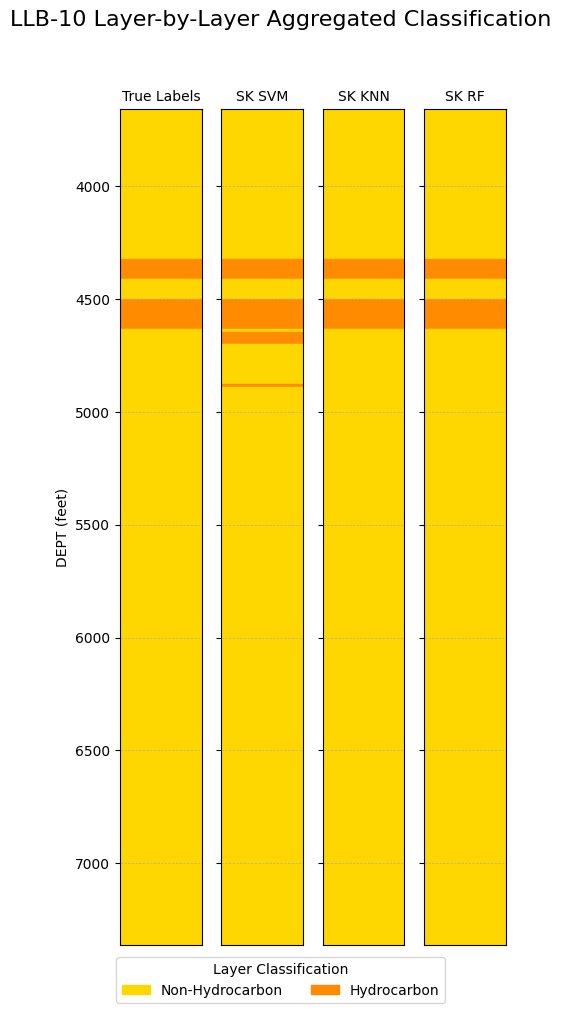

In [49]:
# Visualize LLB-10 layer classification
plot_layer_classification_for_well(layer_summary_results, 'LLB-10')

## Test Wells Layer Analysis


==================== LLD-14 LAYER ANALYSIS ====================
LLD-14 Layer-by-Layer Hydrocarbon Classification Summary (Threshold > 25%):


,Layer,Start_Depth,End_Depth,True_Labels_HC_%,True_Labels_Class,SK_SVM_HC_%,SK_SVM_Class,SK_KNN_HC_%,SK_KNN_Class,SK_RF_HC_%,SK_RF_Class
0,16,3009,3100,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
1,17,3100,3114,0.00%,Non-Hydrocarbon,14.29%,Non-Hydrocarbon,35.71%,Hydrocarbon,0.00%,Non-Hydrocarbon
2,18,3114,3184,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,28.57%,Hydrocarbon,0.00%,Non-Hydrocarbon
3,19,3184,3210,0.00%,Non-Hydrocarbon,55.77%,Hydrocarbon,53.85%,Hydrocarbon,34.62%,Hydrocarbon
4,20,3210,3274,0.00%,Non-Hydrocarbon,10.94%,Non-Hydrocarbon,16.41%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
5,21,3274,3324,0.00%,Non-Hydrocarbon,11.00%,Non-Hydrocarbon,20.00%,Non-Hydrocarbon,6.00%,Non-Hydrocarbon
6,22,3324,3407,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,6.63%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
7,23,3407,3439,0.00%,Non-Hydrocarbon,26.67%,Hydrocarbon,43.33%,Hydrocarbon,28.33%,Hydrocarbon
8,24,3439,3448,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
9,25,3448,3483,0.00%,Non-Hydrocarbon,24.29%,Non-Hydrocarbon,27.14%,Hydrocarbon,15.71%,Non-Hydrocarbon


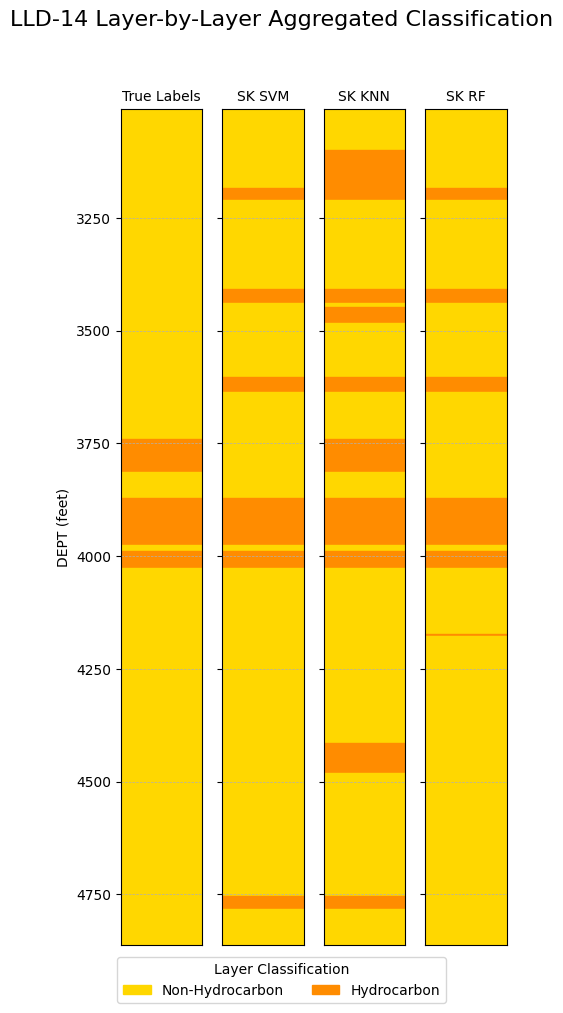


==================== LLA-2 LAYER ANALYSIS ====================
LLA-2 Layer-by-Layer Hydrocarbon Classification Summary (Threshold > 25%):


,Layer,Start_Depth,End_Depth,True_Labels_HC_%,True_Labels_Class,SK_SVM_HC_%,SK_SVM_Class,SK_KNN_HC_%,SK_KNN_Class,SK_RF_HC_%,SK_RF_Class
0,1,3380,3493,0.00%,Non-Hydrocarbon,0.44%,Non-Hydrocarbon,0.44%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
1,2,3493,3509,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
2,3,3509,3583,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
3,4,3583,3603,0.00%,Non-Hydrocarbon,2.50%,Non-Hydrocarbon,10.00%,Non-Hydrocarbon,2.50%,Non-Hydrocarbon
4,5,3603,3674,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,1.41%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
5,6,3674,3758,100.00%,Hydrocarbon,0.60%,Non-Hydrocarbon,7.14%,Non-Hydrocarbon,4.76%,Non-Hydrocarbon
6,7,3758,3859,0.52%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon,0.00%,Non-Hydrocarbon
7,8,3859,3888,0.00%,Non-Hydrocarbon,3.51%,Non-Hydrocarbon,10.53%,Non-Hydrocarbon,1.75%,Non-Hydrocarbon
8,9,3888,3903,0.00%,Non-Hydrocarbon,26.67%,Hydrocarbon,36.67%,Hydrocarbon,33.33%,Hydrocarbon
9,10,3903,3957,0.00%,Non-Hydrocarbon,2.78%,Non-Hydrocarbon,3.70%,Non-Hydrocarbon,2.78%,Non-Hydrocarbon


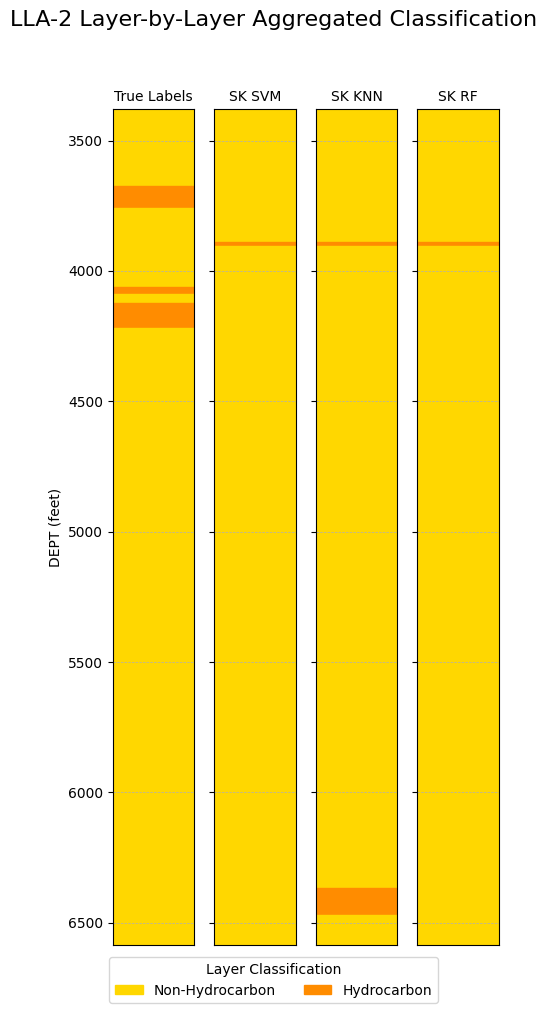

In [50]:
# Analyze layers for all test wells using modular functions
for well_name_test in test_wells:
    print(f"\n{'='*20} {well_name_test} LAYER ANALYSIS {'='*20}")
    
    # Check if layer boundaries exist for this well
    if well_name_test not in layer_boundaries:
        print(f"Warning: No layer boundaries defined for {well_name_test}. Skipping layer analysis.")
        continue
    
    layer_summary_results[well_name_test] = analyze_well_layers(
        well_name=well_name_test,
        data_df=test_wells_data[well_name_test],
        true_labels=test_wells_true_labels[well_name_test],
        sk_predictions=test_wells_sk_pred[well_name_test],
        cu_predictions=test_wells_cu_pred[well_name_test],
        boundaries=layer_boundaries[well_name_test],
        threshold=hydrocarbon_percentage_threshold,
        has_cuml=has_cuml
    )

    # Display the summary table
    print(f"{well_name_test} Layer-by-Layer Hydrocarbon Classification Summary (Threshold > {hydrocarbon_percentage_threshold}%):")
    display(layer_summary_results[well_name_test])
    
    # Visualize layer classification
    plot_layer_classification_for_well(layer_summary_results, well_name_test)

## Resulting Model Accuracy 

In [51]:
# Calculate and display layer-level accuracies using modular functions
all_layer_accuracies = calculate_all_layer_accuracies(layer_summary_results)
print_comprehensive_layer_accuracy_analysis(all_layer_accuracies)

LAYER-LEVEL ACCURACY ANALYSIS

LLB-10 Layer-Level Accuracy:
------------------------------
SK_SVM: 0.9600
SK_KNN: 1.0000
SK_RF: 1.0000

LLD-14 Layer-Level Accuracy:
------------------------------
SK_SVM: 0.8684
SK_KNN: 0.7895
SK_RF: 0.8684

LLA-2 Layer-Level Accuracy:
------------------------------
SK_SVM: 0.9286
SK_KNN: 0.9107
SK_RF: 0.9286

LAYER-LEVEL ACCURACY COMPARISON SUMMARY
 Model  LLB-10 Layer Accuracy  LLD-14 Layer Accuracy  LLA-2 Layer Accuracy
SK_KNN                   1.00               0.789474              0.910714
 SK_RF                   1.00               0.868421              0.928571
SK_SVM                   0.96               0.868421              0.928571


In [52]:
# Execution time
end_notebook = time.time()
print(f"Total notebook execution time: {end_notebook - start_notebook:.2f} seconds")

Total notebook execution time: 40.62 seconds


In [53]:
if is_running_on_colab:
    from google.colab import runtime
    runtime.unassign()